## Connect to Local Runtime
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [1]:
!nvidia-smi

Sun Feb  6 20:43:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 16%   39C    P8    33W / 250W |   1520MiB / 11264MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons import layers as addon_layers
import importlib

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)
# print(addon_layers.__version__)

2.7.0


In [4]:
def assert_shape(x, exp_shape):
    assert x.shape == exp_shape, f"Expected {exp_shape} got {x.shape}"

In [5]:
# Import Project Modules
module_path = os.path.abspath(os.path.join('.')) + "\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models"
print(f"Project module absolute path: {module_path}")
if module_path not in sys.path:
  sys.path.append(module_path)

Project module absolute path: C:\Users\Zeyu Sun\Documents\GitHub\VAE-based-Music--Deep-Generative-Models


In [9]:
import resnet
import data_utils
from utils import tf_utils
import encdec
import VectorQuantizer
import vqvae
from src.transformer import multi_head_attention
from src.transformer import factorized_attention
from src.transformer import transformer
from src.conditioner import conditioners
from src.autoregressive import autoregressive_fmha
import autoregressive

In [10]:
## Reload Module
importlib.reload(resnet)
importlib.reload(encdec)
importlib.reload(VectorQuantizer)
importlib.reload(data_utils)
importlib.reload(vqvae)
importlib.reload(multi_head_attention)
importlib.reload(factorized_attention)
importlib.reload(transformer)
importlib.reload(conditioners)
importlib.reload(autoregressive)
importlib.reload(autoregressive_fmha)

<module 'src.autoregressive.autoregressive_fmha' from 'C:\\Users\\Zeyu Sun\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models\\src\\autoregressive\\autoregressive_fmha.py'>

## DataSet

In [11]:
## DEV
s = 'GENERATIVE_DATA/GTZAN/genres_original/hiphop/hiphop.00063.wav'
s.split('/')[-1]

'hiphop.00063.wav'

### GTZAN

In [12]:
DATA_PATH = "GENERATIVE_DATA/GTZAN/genres_original/"

## Data Loading
### 28160 / 2^(5 + 3) is integer
MAX_SIGNAL_LEN = 28160 #28000 #10240 # 80000

### Compressed 30 s audio
SAMPLE_RATE=  3000 #3000
DURATION= 10

QUANTIZATION_CHANNELS = 256 # 8bit

GENRES = {'metal': 0, 'disco': 1, 'classical': 2, 'rock': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'hiphop': 9}

In [13]:
# DEV
sample = data_utils.load_audio(DATA_PATH+'hiphop/hiphop.00032.wav', sr=SAMPLE_RATE, duration=DURATION, mono=False)
print("Sample Signal Shape: {}, sample Rate: {}".format(sample.shape, SAMPLE_RATE))
ipd.Audio(sample, rate=SAMPLE_RATE)

Sample Signal Shape: (1, 30001), sample Rate: 3000


0.64707106 -0.67217755


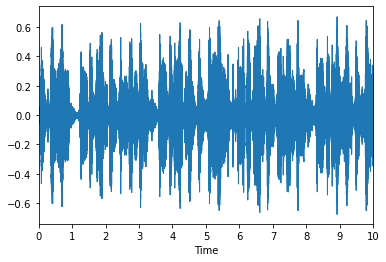

In [14]:
print(np.amax(sample), np.amin(sample))
## Waveplot
librosa.display.waveplot(sample[0], sr=SAMPLE_RATE)

In [15]:
# Read The Data
# TODO: save the TF DataSet!
X_train, y_train, y_file_train, X_test, y_test, y_file_test = data_utils.read_data(DATA_PATH, GENRES, sample_rate=SAMPLE_RATE, duration=DURATION, max_signal_len=MAX_SIGNAL_LEN, test_data_percentage=0.05)

Loading Audio files under Genere: metal
Loading Audio files under Genere: disco
Loading Audio files under Genere: classical
Loading Audio files under Genere: rock
Loading Audio files under Genere: jazz
Skipping file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00054.wav...
Loading Audio files under Genere: country
Loading Audio files under Genere: pop
Loading Audio files under Genere: blues
Loading Audio files under Genere: reggae
Loading Audio files under Genere: hiphop
Loading and Preprocessing Testing data......
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/rock/rock.00021.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/classical/classical.00089.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/classical/classical.00052.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/pop/pop.00060.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00055.wav

In [ ]:
### Get File Label Also
# Extract Full audio for each song (<=30s), then split into
# 1 audio -> 3 chunks (3C); besides last C, 2C splits into 9 pieces -> offset == 2C/9
X_train, y_train, y_file_train, X_test, y_test, y_file_test = data_utils.read_data(DATA_PATH, GENRES, sample_rate=SAMPLE_RATE, duration=30, max_signal_len=MAX_SIGNAL_LEN*3, split_window=1/3, split_overlap=7/9, shuffle_after_split=True)

In [16]:
print(type(X_train), X_train.shape, X_test.shape, y_train.shape, X_test.shape)
print(y_file_train.shape, y_file_test.shape)

print(y_train[:20])
print(set(y_train), set(y_test))

## Debug Inspect samples
### 2: classical, 9: hip-hop
hiphop_idx = np.where(y_train==2)[0]
print(hiphop_idx[:10])
ipd.Audio(X_train[hiphop_idx[2]], rate=SAMPLE_RATE)
# ipd.Audio(X_train[hiphop_idx[2]], rate=22050) # raw file

<class 'numpy.ndarray'> (949, 1, 28160) (50, 1, 28160) (949,) (50, 1, 28160)
(949,) (50,)
[1 0 0 5 5 5 7 9 5 0 5 2 2 7 0 0 5 3 2 6]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[ 11  12  18  33  40  42  47  76  80 100]


949 50


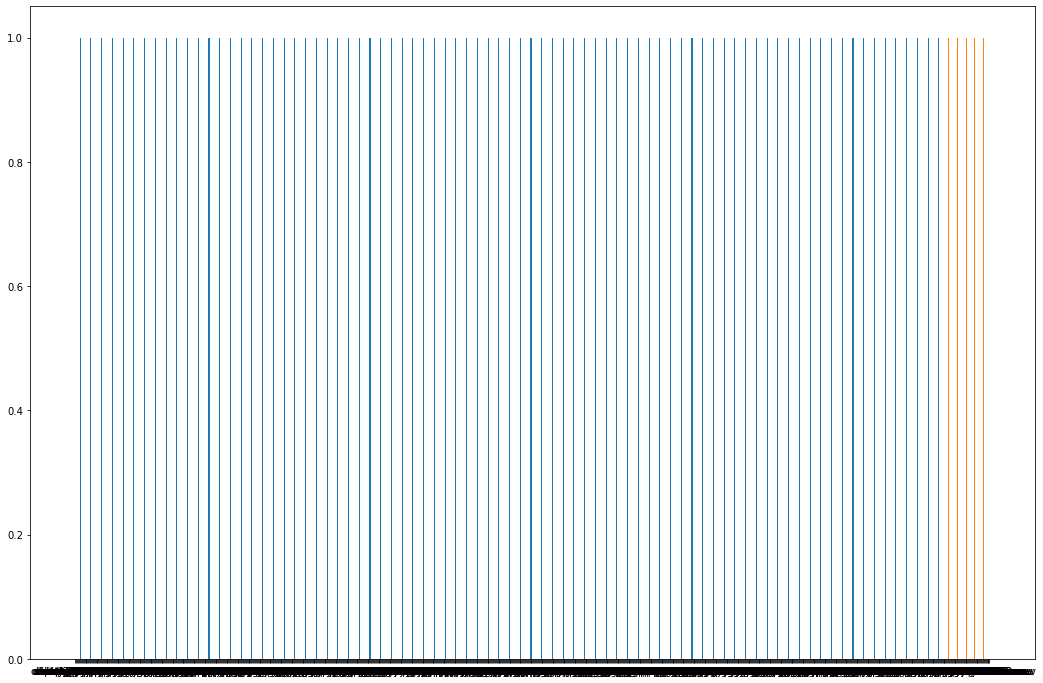

In [17]:
## Stratify by file label 
print(len(np.unique(y_file_train)), len(np.unique(y_file_test)))
fig = plt.figure(figsize=(18, 12))
n_file_train, bins_file_train, _ = plt.hist(y_file_train, bins=len(np.unique(y_file_train)), histtype='bar', rwidth=0.1)
n_file_test, bins_file_test, _ = plt.hist(y_file_test, bins=len(np.unique(y_file_test)), histtype='bar', rwidth=0.1)

In [18]:
X_train_T = X_train.transpose([0,2,1]) # (N, T, 1)
X_test_T = X_test.transpose([0, 2, 1])

In [19]:
print(X_train_T.shape, X_test_T.shape)
ipd.Audio(X_train_T[hiphop_idx[2]].flatten(), rate=SAMPLE_RATE)

(949, 28160, 1) (50, 28160, 1)


In [20]:
BATCH_SIZE = 8 #16 #8
TRAIN_SHUFFLE_SIZE = 1000 #9000 #2800 #1000
NUM_GENERES = len(np.unique(y_train))

In [21]:
## Load to TF DataSet (numpy to TF Tensor)
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_T, y_train))
                 .shuffle(TRAIN_SHUFFLE_SIZE)
                 .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test_T, y_test))
                 .batch(BATCH_SIZE))

In [22]:
print(np.amax(X_train_T), np.amin(X_train_T))
# print(np.amax(list(train_dataset.as_numpy_iterator())))
print(np.amax(X_test_T), np.amin(X_test_T))

1.25347 -1.2156466
1.0747001 -1.1673799


In [23]:
### Example batch
sample_batch, sample_labels = next(iter(train_dataset))
print(sample_batch.shape)
print(sample_labels.shape, sample_labels)
print(sample_batch[0].numpy().squeeze())
print(tf.math.reduce_max(sample_batch).numpy(), tf.math.reduce_min(sample_batch).numpy(), )

(8, 28160, 1)
(8,) tf.Tensor([6 2 0 5 4 8 5 1], shape=(8,), dtype=int32)
[0.02247773 0.05145083 0.04238656 ... 0.10620471 0.09514333 0.00822746]
1.025513 -1.0227605


#### DAta Distribution

Uniques in Train: [0 1 2 3 4 5 6 7 8 9], Unique in Test: [0 1 2 3 4 5 6 7 8 9]


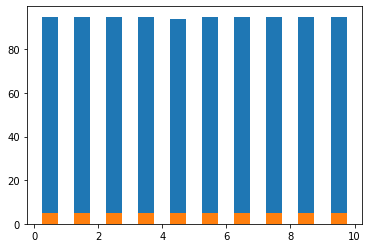

In [24]:
print(f"Uniques in Train: {np.unique(y_train)}, Unique in Test: {np.unique(y_test)}")
n_train, bins_train, _ = plt.hist(y_train, bins=np.arange(11), histtype='bar', rwidth=0.5)
n_test, bins_test, _ = plt.hist(y_test, bins=np.arange(11), histtype='bar', rwidth=0.5)

In [25]:
n_train

array([95., 95., 95., 95., 94., 95., 95., 95., 95., 95.])

In [26]:
n_test

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

####Training Data Samples (1 per genre)

In [27]:
## Multiple Genres Case
idx_to_genres = {v:k for (k, v) in GENRES.items()}
# create a dict of each unique entry and the associated indices
generes_train_idx = {v: np.where(y_train == v)[0].tolist()[:6] for v in np.unique(y_train)}

print(generes_train_idx)

train_samples = []

for i in range(NUM_GENERES):
  train_samples.append(X_train_T[int(generes_train_idx[i][0])])
  # Quantization Version
  # train_samples.append(X_train_Q[int(generes_train_idx[i][0])])

# Numpy Array
train_samples = np.stack(train_samples, axis=0)
print(train_samples.shape, train_samples[0])

{0: [1, 2, 9, 14, 15, 20], 1: [0, 22, 45, 68, 77, 92], 2: [11, 12, 18, 33, 40, 42], 3: [17, 34, 35, 39, 44, 54], 4: [23, 28, 30, 32, 48, 53], 5: [3, 4, 5, 8, 10, 16], 6: [19, 21, 27, 37, 41, 49], 7: [6, 13, 29, 46, 51, 56], 8: [26, 38, 73, 87, 107, 108], 9: [7, 55, 61, 71, 99, 125]}
(10, 28160, 1) [[0.06676502]
 [0.18918084]
 [0.09486801]
 ...
 [0.20978655]
 [0.00706793]
 [0.01383145]]


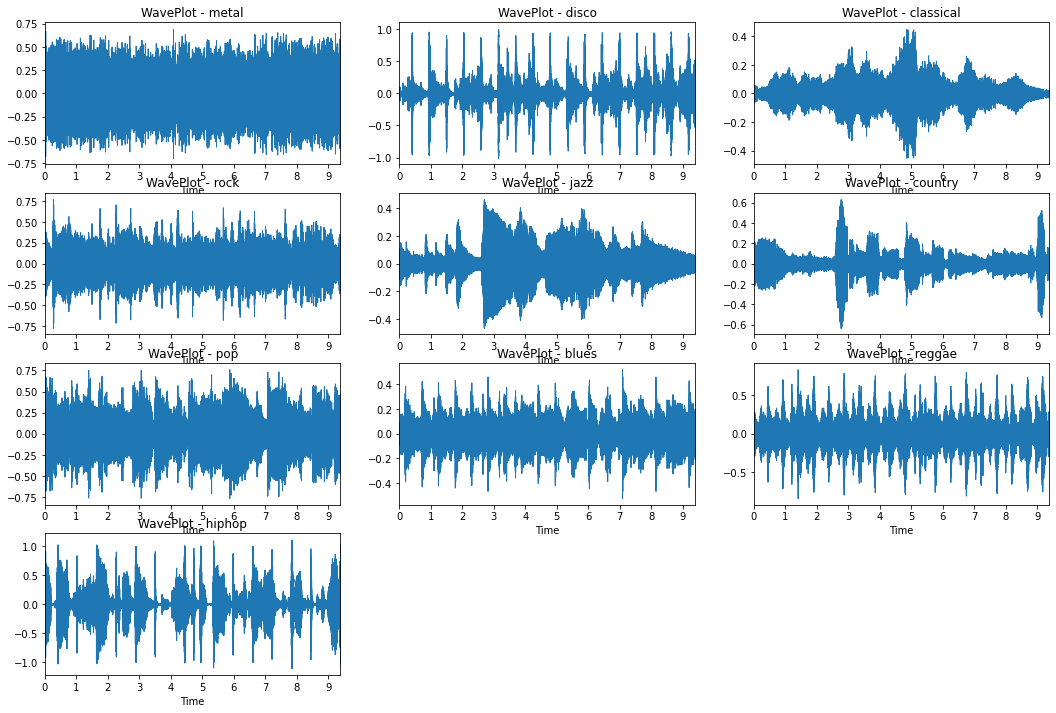

In [28]:
fig = plt.figure(figsize=(18, 12))

for i in range(train_samples.shape[0]):
    
  plt.subplot(4, 3, i + 1)

  librosa.display.waveplot(train_samples[i].squeeze(), sr=SAMPLE_RATE)

  plt.title(f"WavePlot - {idx_to_genres[i]}")
  # plt.tight_layout()
  
plt.show()

In [29]:
### Train Samples
ipd.Audio(train_samples[2].flatten(), rate=SAMPLE_RATE)

In [30]:
# Test Samples
test_samples = data_utils.generate_genre_samples(X_test_T, y_test)
ipd.Audio(test_samples[2].flatten(), rate=SAMPLE_RATE)

{0: [10, 19, 24, 41, 42], 1: [5, 23, 31, 39, 48], 2: [1, 2, 25, 32, 45], 3: [0, 9, 26, 40, 49], 4: [4, 8, 13, 15, 17], 5: [6, 29, 35, 44, 47], 6: [3, 12, 18, 21, 30], 7: [7, 20, 27, 33, 34], 8: [16, 22, 36, 37, 43], 9: [11, 14, 28, 38, 46]}
(10, 28160, 1) [[ 0.0306365 ]
 [-0.01742711]
 [-0.01944193]
 ...
 [-0.07686737]
 [ 0.06053103]
 [ 0.13474897]]


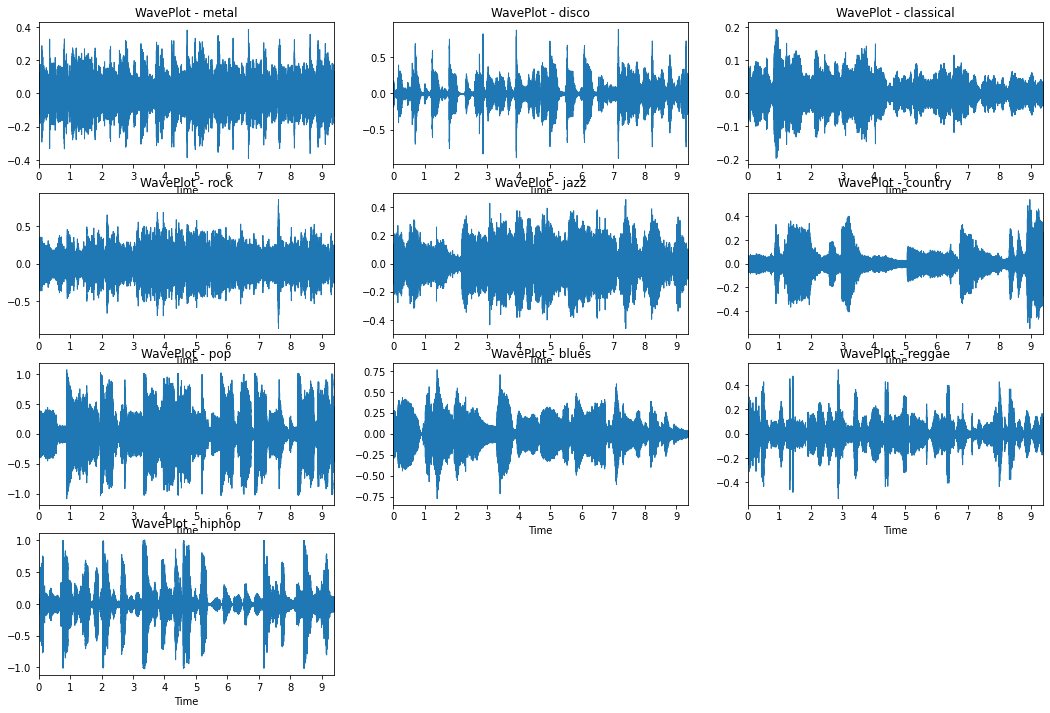

In [31]:
fig = plt.figure(figsize=(18, 12))

for i in range(test_samples.shape[0]):
    
  plt.subplot(4, 3, i + 1)

  librosa.display.waveplot(test_samples[i].squeeze(), sr=SAMPLE_RATE)

  plt.title(f"WavePlot - {idx_to_genres[i]}")
  
plt.show()

## Model Structure

### VQ

### Trainer

In [ ]:
multi_head_attention.dummy_module()

'HHH'

In [ ]:
# vqvae_trainer = VQVAETrainer(sample_batch.shape[1:], latent_dim=64, num_embeddings=512, depth=1, down_depth=[5], strides=[2]) # codebook size
# vqvae_trainer.compile(optimizer=keras.optimizers.Adam()) #, run_eagerly=True) # eager mode for debug...
## Load From Module
# vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=1, latent_dim=64, num_embeddings=512, down_depth=[8], strides=[2], dilation_factor=3, residual_width=32) #  Debug when NT < K
# bottom-middle-top structure
vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=3, latent_dim=64, num_embeddings=512, down_depth=[3, 2, 2], strides=[2, 2, 2], dilation_factor=3, residual_width=32) # codebook size
# vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=2, latent_dim=64, num_embeddings=512, down_depth=[5, 3], strides=[2, 2], dilation_factor=3, residual_width=32) # codebook size
# vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=1, latent_dim=64, num_embeddings=512, down_depth=[5], strides=[2], dilation_factor=3)
# vqvae_trainer.compile(optimizer=keras.optimizers.Adam()) #, run_eagerly=True) # eager mode for debug...

Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 1
Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 1
Adding EncoderConvBlock: 2
Adding DecoderConvBlock: 0
Adding DecoderConvBlock: 1
Adding DecoderConvBlock: 0
Adding DecoderConvBlock: 2
Adding DecoderConvBlock: 1
Adding DecoderConvBlock: 0


In [ ]:
# vqvae_trainer.vqvae(sample_batch)
# vqvae_trainer.vqvae.summary()
for vqvae_ in vqvae_trainer.vqvaes:
  vqvae_.summary()

In [ ]:
# encdec.print_dec_layer(vqvae_trainer.decoder) # Check Dilation pattern

In [ ]:
print(vqvae_trainer.metrics)
# print(vqvae_trainer.vq.metrics)
for vq in vqvae_trainer.vqs:
  for m in vq.metrics:
    print(m.name) 
d = {m.name : m.result() for m in vqvae_trainer.vqs[0].metrics}
d

[<keras.metrics.Mean object at 0x000002013E0E3970>, <keras.metrics.Mean object at 0x000002013F3DF6D0>, <keras.metrics.Mean object at 0x000002013E234E20>, <keras.metrics.Mean object at 0x000002013E0D5610>, <keras.metrics.Mean object at 0x000002013E0000D0>, <keras.metrics.Mean object at 0x000002013E000910>, <keras.metrics.Mean object at 0x000002013E1E0E50>, <keras.metrics.Mean object at 0x000002013F2F8FD0>, <keras.metrics.Mean object at 0x000002013E216EE0>, <keras.metrics.Mean object at 0x000002013E216430>, <keras.metrics.Mean object at 0x000002013F3B6970>, <keras.metrics.Mean object at 0x000002013F3B6A00>, <keras.metrics.Mean object at 0x000002013E1D77F0>, <keras.metrics.Mean object at 0x000002013F2F6310>, <keras.metrics.Mean object at 0x0000020139662640>, <keras.metrics.Mean object at 0x0000020139662190>]
[0]batch_codebook_usage
[0]codebook_usage
[0]codebook_entropy
[1]batch_codebook_usage
[1]codebook_usage
[1]codebook_entropy
[2]batch_codebook_usage
[2]codebook_usage
[2]codebook_entro

{'[0]batch_codebook_usage': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 '[0]codebook_usage': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 '[0]codebook_entropy': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [ ]:
dict(hhh=1.0, rere=2.0)

{'hhh': 1.0, 'rere': 2.0}

In [ ]:
#DEV VQ
# vqvae_trainer.get_quantizer().N_t
# print(vqvae_trainer.get_quantizer().embeddings)
# print(vqvae_trainer.get_quantizer().get_usage_count())
print(vqvae_trainer.vqs[0].trainable_variables)
# print(vqvae_trainer.vq.get_weights())
# for w, var in zip(vqvae_trainer.vq.get_weights(), vqvae_trainer.vq.variables):
#     print("Variable: "+var.name)
#     print(w.shape)
#     print(w)
# print(vqvae_trainer.vqvaes[0].trainable_variables)

[]


In [ ]:
print(sum([np.prod(var.numpy().shape) for var in vqvae_trainer.vqvaes[0].trainable_variables]))

186497


##### Validation

In [ ]:
#### Validation between Epoches TODO: move to module
'''
 sample latent z based on actual test data x
'''
def generate_and_save_waves(model, epoch, test_sample, if_quantized=False, channel_last=False, print_codebook_distribution=False):

  ## Codebook Vector usage (Put ahead reconstruction, given that vq preserve the last N_t for now)
  if print_codebook_distribution:
    vq_usage = model.get_quantizer().get_usage_count()
    print("Snapshot of Codebook Vector usage, Size(K/D, ): {}; SUM (last Batch size x latent_len){} ".format(tf.shape(vq_usage), tf.math.reduce_sum(vq_usage)))
    fig = plt.figure(figsize=(10, 5))
    plt.title("VQ Codebook Vector Usage Count")
    # plt.hist(vq_usage.numpy()) # should use bar...
    plt.bar(x=np.arange(len(vq_usage)), height=vq_usage.numpy())
    plt.show()

  print("[DEBUG] TOTAL Number of Trainable Weights for model: {}".format(sum([np.prod(var.numpy().shape) for var in model.trainable_variables])))

  # Direct Reconstruction (x -> x')
  input = test_sample
  if channel_last:
    input = np.transpose(test_sample, [0,2,1])
  predictions = model(input).numpy()
  print("Reconstructed Output: ", predictions.shape)
  fig = plt.figure(figsize=(18, 12))
  ret = []

  if if_quantized: # mu-law transformation
    # recover int waveform to float waveform
    # Greedy Sampling
    predictions = np.argmax(predictions, axis=-1)
    print("Sampled quantized: ", predictions.shape, predictions[0])

    predictions = mu_law_decode(predictions, QUANTIZATION_CHANNELS)

    print("Max: {}, Min: {}".format(np.amax(predictions), np.amin(predictions)))

  for i in range(predictions.shape[0]):
    waves = predictions[i]
    plt.subplot(4, 3, i + 1)

    if i==9:
      print("X': ", waves.squeeze())
      print(f"X range: [{np.amax(waves)}, {np.amin(waves)}]")

    librosa.display.waveplot(waves.squeeze(), sr=SAMPLE_RATE)
    plt.title(f"WavePlot - {idx_to_genres[i]}")
    # plt.tight_layout()
    ret.append(predictions[i])
    
  plt.show()


  return ret

In [ ]:
1e-4

0.0001

In [ ]:
# Callbacks
class VAEMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, **kwargs):
        super(VAEMonitor, self).__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
      ## DEBUG
      for level in range(self.model.levels):
        print("\n-------------------------Epoch: {}, Level: {}------------------------------".format(epoch, level))
        vq = self.model.vqs[level]
        codebook_usage = tf.reduce_sum(tf.cast(vq.get_usage_count() >= 1.0, dtype=tf.float32))
        collapsed_code = tf.reduce_sum(tf.cast(vq.get_usage_count() <= 0.0, dtype=tf.float32))
        print("\n[VQ DEBUG] Snap shot of N_t: {}; Code<=0... {}".format(codebook_usage, collapsed_code))
        # Reset the metrics!!!
        print("\nResetting the metrics...")
        for m in self.model.vqvaes[level].metrics:
          m.reset_state()
        for m in self.model.vqs[level].metrics:
          m.reset_state()

      # Periodic Inspect
      if epoch % 5 == 0:
        print("\n[DEBUG] This is Callback Monitor: End of Epoch", epoch)
        print("---------------------------Running Validation DataSet---------------------------")
        self.model.evaluate(test_dataset)
        for level in range(self.model.levels):
          print("-------------------------------ReConstruction of Training Samples for Level: {}-------------------------------".format(level))
          generate_and_save_waves(self.model.vqvaes[level], epoch, train_samples)
        # generate_and_save_waves(self.model, epoch, train_samples, if_quantized=True, channel_last=True)

vae_monitor = VAEMonitor()

In [ ]:
15e-5

0.00015

In [ ]:
# Callback 0: Learning Rate Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, verbose=1, min_lr=0.0000001, min_delta=1.0)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam()) # 15e-5 for jukebox paper ('vqvae' model)

vqvae_trainer.fit(train_dataset, epochs=300, callbacks=[vae_monitor, reduce_lr])

In [ ]:
#### Inspect reconstructed sample
# recon_train_samples = generate_and_save_waves(vqvae_trainer, 0, train_samples) #TODO: need to assign which level of vqvae...
recon_train_samples_bottom = generate_and_save_waves(vqvae_trainer.vqvaes[0], 0, train_samples) #TODO: need to assign which level of vqvae...

In [ ]:
### Middle Level (TODO)
recon_train_samples_mid = generate_and_save_waves(vqvae_trainer.vqvaes[1], 0, train_samples) #TODO: need to assign which level of vqvae...

In [ ]:
### TOP Leve
recon_train_samples_top = generate_and_save_waves(vqvae_trainer.vqvaes[-1], 0, train_samples) #TODO: need to assign which level of vqvae...

In [ ]:
ipd.Audio(train_samples[2].squeeze(), rate=SAMPLE_RATE)

In [ ]:
ipd.Audio(recon_train_samples_bottom[9].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
ipd.Audio(recon_train_samples_mid[2].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
ipd.Audio(recon_train_samples_top[2].squeeze(), rate=SAMPLE_RATE) # Metal Recon

## Storage, Checkpointing...

In [32]:
VERSION = "double_separate_vqvae" #"3_levels_322_separate_vqvae" #
local_storage_path = './colab_storage/VQVAE/cp/{}/'.format(VERSION)

In [33]:
loaded_vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=2, latent_dim=64, num_embeddings=512, down_depth=[5, 3], strides=[2, 2], dilation_factor=3, residual_width=32) # Two Level VQ-VAEs codebook size

Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 1
Adding DecoderConvBlock: 0
Adding DecoderConvBlock: 1
Adding DecoderConvBlock: 0


In [ ]:
# Svae Model
# vqvae_trainer.save(local_storage_path)
for level in range(vqvae_trainer.levels):
    # vqvae_trainer.encoders[level].save_weights("{}{}/{}".format(local_storage_path, "encoder", level))
    # vqvae_trainer.decoders[level].save_weights("{}{}/{}".format(local_storage_path, "decoder", level))
    # vqvae_trainer.vqs[level].save_weights("{}{}/{}".format(local_storage_path, "vq", level))
    vqvae_trainer.vqvaes[level].save_weights("{}{}/{}".format(local_storage_path, "vqvae", level))

In [34]:
loaded_vqvae_trainer.vqs[0].N_t
# Validation
initial_codebook = loaded_vqvae_trainer.vqs[0].embeddings.numpy()
initial_enc_weights = loaded_vqvae_trainer.encoders[0].get_weights() # already NP arr[w.numpy() for w in loaded_vqvae_trainer.encoders[0].get_weights()]
initial_dec_weights = loaded_vqvae_trainer.decoders[0].get_weights() #[w.numpy() for w in loaded_vqvae_trainer.decoders[0].get_weights()]

In [35]:
# Load Model
for level in range(loaded_vqvae_trainer.levels):
    # vqvae_trainer.encoders[level].save_weights("{}{}/{}".format(local_storage_path, "encoder", level))
    # vqvae_trainer.decoders[level].save_weights("{}{}/{}".format(local_storage_path, "decoder", level))
    # vqvae_trainer.vqs[level].save_weights("{}{}/{}".format(local_storage_path, "vq", level))
    print("--------- Loading Models from Level: {}".format(level))
    loaded_vqvae_trainer.vqvaes[level].load_weights("{}{}/{}".format(local_storage_path, "vqvae", level))

--------- Loading Models from Level: 0
--------- Loading Models from Level: 1


In [ ]:
# loaded_codebook = loaded_vqvae_trainer.vqs[0].embeddings
# print(loaded_codebook == initial_codebook)
# loaded_enc_weights = loaded_vqvae_trainer.encoders[0].get_weights()
# for w1, w2 in zip(initial_enc_weights, loaded_enc_weights):
#   print(w1==w2)

In [ ]:
## Resume Training
loaded_vqvae_trainer.compile(optimizer=keras.optimizers.Adam(15e-5)) # 15e-5 for jukebox paper ('vqvae' model)

loaded_vqvae_trainer.fit(train_dataset, epochs=100, callbacks=[vae_monitor, reduce_lr])

[DEBUG] TOTAL Number of Trainable Weights for model: 496705
Reconstructed Output:  (10, 28160, 1)
X':  [-0.03343744 -0.02486749 -0.02721648 ...  0.01390619  0.00939042
  0.01048   ]
X range: [1.0001736879348755, -1.1907507181167603]


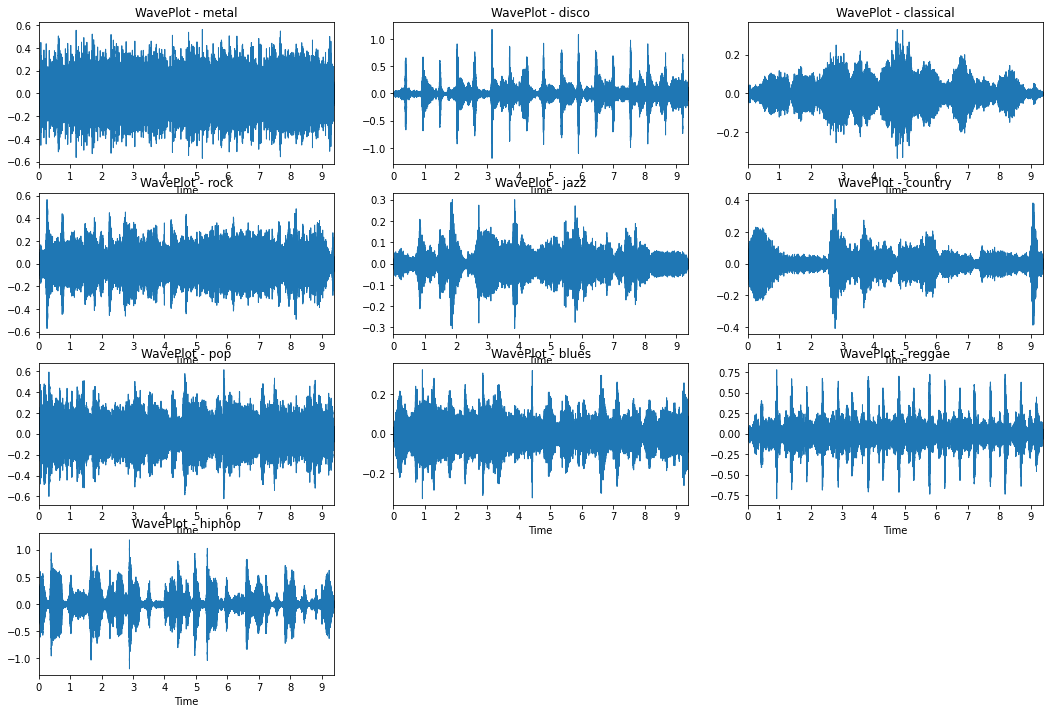

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.02448012  0.07036518  0.06209352 ... -0.04030317 -0.08214217
 -0.14540997]
X range: [1.1158572435379028, -1.2354013919830322]


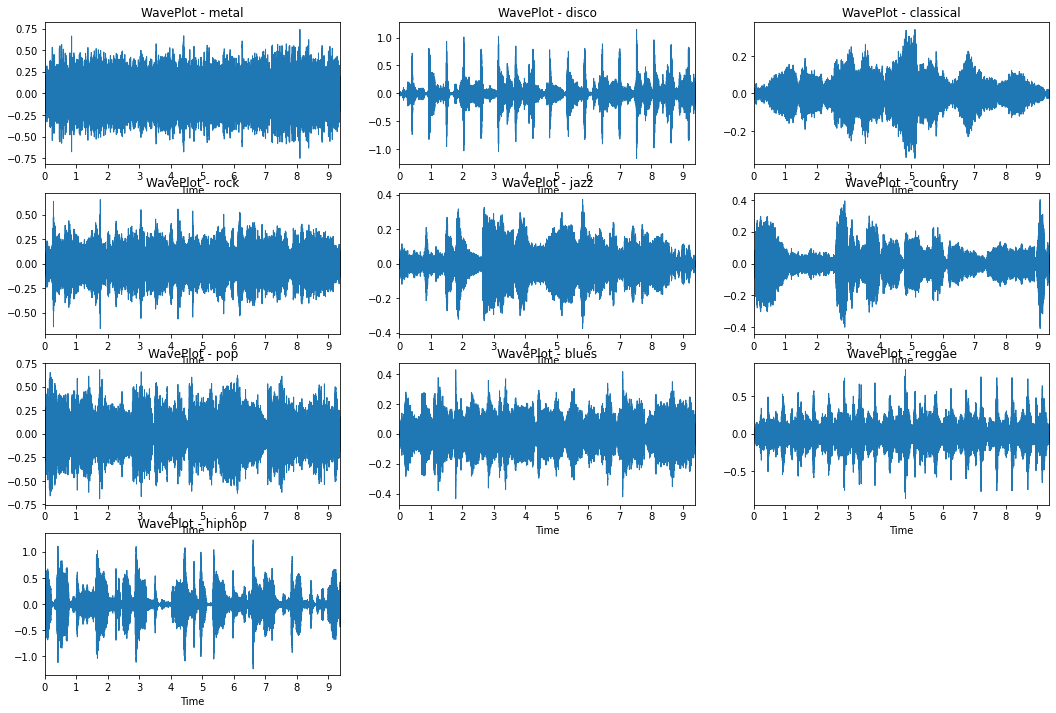

In [36]:
recon_train_samples_top_ = tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=1) #TODO: need to assign which level of vqvae...
recon_train_samples_bottom_ = tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=0) #TODO: need to assign which level of vqvae...

In [37]:
ipd.Audio(recon_train_samples_top_[2].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [38]:
ipd.Audio(recon_train_samples_bottom_[2].squeeze(), rate=SAMPLE_RATE) # Classic Recon

## Prior and Up-Sampler

#### Multi-Head Attention (Self-Attention if no lyric conditioning...)

## Factorized Attention

In [ ]:
## Take the first Head
ah = mha_attn_block[:, 1, ...]
for i in tf.range(ah.shape[0]):
  print(ah[i].numpy())

In [ ]:
ah.get_shape().as_list()

[16, 4, 4]

## Latent Code Generation

In [39]:
from utils import tf_utils
import time
from src.transformer import transformer
from src.transformer import multi_head_attention
from src.transformer import factorized_attention
from src.conditioner import conditioners
import autoregressive


importlib.reload(autoregressive)
importlib.reload(data_utils)
importlib.reload(tf_utils)
importlib.reload(multi_head_attention)
importlib.reload(factorized_attention)
importlib.reload(transformer)
importlib.reload(conditioners)
importlib.reload(autoregressive_fmha)

<module 'src.autoregressive.autoregressive_fmha' from 'C:\\Users\\Zeyu Sun\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models\\src\\autoregressive\\autoregressive_fmha.py'>

#### Bottom Level CODE
TODO: Move this to be modular

In [40]:
X_train_T.shape
sample_batch.shape
LEVEL=0 # 0 for bottom

In [41]:
ini_emb = loaded_vqvae_trainer.vqs[0].embeddings.numpy()

In [42]:
def get_latent_codes(vqvae, x, level=0):
  enc_outputs = vqvae.encoders[level](x, training=False) # (N, T_downsampled, C)
  latent_dim = tf.shape(enc_outputs)[-1]
  # print(enc_outputs.shape)
  # latent_output, latent_codes = vqvae.vqs[level](tf.reshape(enc_outputs, [-1, latent_dim]), training=False)
  latent_output, latent_codes = vqvae.vqs[level](enc_outputs, training=False)
  # print(latent_output.shape, latent_codes.shape)
  latent_codes = tf.reshape(latent_codes, tf.shape(enc_outputs)[:-1])
  # print(latent_codes.shape, latent_codes.dtype)
  return latent_output, latent_codes

In [43]:
# vq_out_bottom, latent_codes_bottom = get_latent_codes(loaded_vqvae_trainer, X_train_T, level=0)
# (N, T, C); (N, T)
sample_vq_out_bottom, sample_latent_codes_bottom = get_latent_codes(loaded_vqvae_trainer, sample_batch, level=0)

In [44]:
## Top Level, extra 2^3=8 hoplength (32*8 = 256)
sample_vq_out_top, sample_latent_codes_top = get_latent_codes(loaded_vqvae_trainer, sample_batch, level=1)

In [45]:
## Make Sure No More Update/Training of vqs' embeddings!
print(tf.reduce_sum(tf.cast(loaded_vqvae_trainer.vqs[0].embeddings != ini_emb, tf.float32)))

tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
# Validate if the latent codes is legit...
vq = loaded_vqvae_trainer.vqs[0]
quantized = tf.matmul(tf.one_hot(sample_latent_codes_bottom, vq.num_embeddings), vq.embeddings, transpose_b=True)
# print(quantized != tf.reshape(sample_vq_out_bottom, quantized.shape))
# print(tf_utils.compare_t(quantized, sample_vq_out_bottom)) # still diff... due to precision?
## Reconstruction from latent codes
recon = loaded_vqvae_trainer.decoders[0](quantized).numpy() # (N, T, 1)
ipd.Audio(recon[0].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
recon = loaded_vqvae_trainer.decode(sample_latent_codes_bottom, level=0) # (N, T, 1)
ipd.Audio(recon[0].numpy().squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
# Original
ipd.Audio(sample_batch[0].numpy().squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
# VQ-VAE E2E pass through
e2e_recon = loaded_vqvae_trainer.vqvaes[0](sample_batch, training=False)
ipd.Audio(e2e_recon[0].numpy().squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
e2e_recon.shape, recon.shape
print(tf.squeeze(e2e_recon[0]))
print(tf.squeeze(recon[0]))
# tf_utils.compare_t(e2e_recon, recon)
print(tf.reduce_max(tf.math.abs(e2e_recon - recon), axis=[-2, -1])) # Still Diff, but ~< 1e-7

tf.Tensor(
[ 0.00544018 -0.0005243  -0.00678004 ... -0.00799603 -0.01420973
 -0.00270288], shape=(28160,), dtype=float32)
tf.Tensor(
[ 0.00544017 -0.0005243  -0.00678004 ... -0.00799603 -0.01420973
 -0.00270288], shape=(28160,), dtype=float32)
tf.Tensor(
[1.6391277e-07 1.0132790e-06 3.5762787e-07 2.3841858e-07 3.5762787e-07
 1.7881393e-07 4.1723251e-07 9.5367432e-07], shape=(8,), dtype=float32)


In [ ]:
tf_utils.compare_t(loaded_vqvae_trainer.vqs[0].embeddings, ini_emb) # Extra Paranoid...

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(64, 512), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)

In [ ]:
_, train_samples_latent_bottom = get_latent_codes(loaded_vqvae_trainer, train_samples, level=0)
print(train_samples_latent_bottom.shape) # (10, T_l)
_, train_samples_latent_top = get_latent_codes(loaded_vqvae_trainer, train_samples, level=1)
print(train_samples_latent_top.shape)

(10, 880)
(10, 110)


In [ ]:
## Plot the recon result
_ = tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=0, if_decode=True, latent_code=train_samples_latent_bottom)

In [ ]:
_ = tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=1, if_decode=True, latent_code=train_samples_latent_top)

In [ ]:
### Validate No further update to the VQ Codebook
print(tf.reduce_sum(tf.cast(loaded_vqvae_trainer.vqs[0].embeddings != ini_emb, tf.float32)))

tf.Tensor(0.0, shape=(), dtype=float32)


### Why Poor Testset performance

In [ ]:
test_seq = []
for (batch, (X, Y)) in enumerate(test_dataset):
    print(batch)
    quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, X, level=LEVEL) # (N, T_compressed)
    test_seq.append(latent_codes)
    print(type(latent_codes), latent_codes.shape)
test_seq = tf.concat(test_seq, axis=0)

In [ ]:
print(test_seq.shape)
fig = plt.figure(figsize=(18, 10))
# test_n, test_bins, _ = plt.hist(test_seq)
test_n, test_bins, _ = plt.hist(test_seq.numpy().flatten(), rwidth=0.8, bins=CODEBOOK_SIZE)
# plt.legend()

In [ ]:
test_n.shape, test_bins.shape
# test_n

((513,), (514,))

In [ ]:
train_seq = []
for (batch, (X, Y)) in enumerate(train_dataset):
    # print(batch)
    quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, X, level=LEVEL) # (N, T_compressed)
    # print(type(latent_codes), latent_codes.shape)
    train_seq.append(latent_codes)

train_seq = tf.concat(train_seq, axis=0)

In [ ]:
print(train_seq.shape)
fig = plt.figure(figsize=(18, 10))
# train_n, train_bins, _ = plt.hist(train_seq)
train_n, train_bins, _ = plt.hist(train_seq.numpy().flatten(), rwidth=0.8, bins=CODEBOOK_SIZE)

In [ ]:
train_n.shape, train_bins.shape
# print(train_bins, test_bins)

((513,), (514,))

In [ ]:
## Test if VQ is altered
ini_emb_bottom = loaded_vqvae_trainer.vqs[0].embeddings.numpy()
ini_emb_top = loaded_vqvae_trainer.vqs[1].embeddings.numpy()

In [ ]:
ini_emb_top.shape

(64, 512)

### Prior Training

In [46]:
EPOCHS = 1000
CODEBOOK_SIZE = 512 + 1 # Trick, let start token being 512
MHA_HEADS = 1 #4
MHA_MODEL =  256 #128
MHA_DEPTH = 18 #6
MAXIMUM_POS_ENCODING = 1000

ATTN_STACKS = 1 # (row, col, prev_row)
BLOCKS = 55  # For bottom: 880 = 55 * 16
DROP_OUT_RATE=0.0

Text(0.5, 0, 'Train Step')

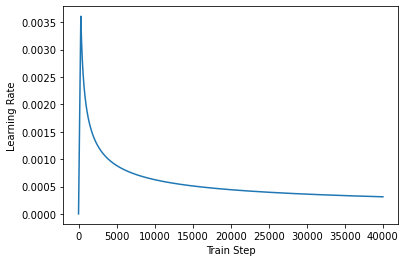

In [47]:
temp_learning_rate_schedule = multi_head_attention.CustomSchedule(MHA_MODEL, warmup_steps=300)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [48]:
# automha_optimizer = keras.optimizers.Adam(1e-3) # TODO: LR Schedule
learning_rate = multi_head_attention.CustomSchedule(MHA_MODEL, warmup_steps=4000)

automha_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
ent_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [50]:
print(sample_latent_codes_bottom.shape[1:], sample_latent_codes_bottom.shape)
print(sample_latent_codes_top.shape[1:], sample_latent_codes_top.shape)
LEVEL

(880,) (8, 880)
(110,) (8, 110)


0

In [55]:
Z_SHAPES = [sample_latent_codes_bottom.shape[1:], sample_latent_codes_top.shape[1:]]
DOWNS=[5, 3]
STRIDES=[2,2]
LEVELS=2
X_COND_KWAEGS = dict(dilation_factor=3, dilation_cycle=4, residual_width=64, residual_depth=8)

In [56]:
# del automha
# sample_in = tf.random.uniform((32, 4), dtype=tf.int64, minval=1, maxval=200)
# print(sample_in)
# For Bottom Level VQ-VAE
# automha = autoregressive.MHABasedAutoregressiveModel(context_length=sample_latent_codes_bottom.shape[1:], target_vocab_size=CODEBOOK_SIZE, width=MHA_MODEL, depth=MHA_DEPTH,
#                                           heads=MHA_HEADS, maximum_pos_encoding=MAXIMUM_POS_ENCODING)
## Factorized Transformer Based Prior

# automha = autoregressive_fmha.FMHABasedAutoregressiveModel(context_length=sample_latent_codes_bottom.shape[1:], target_vocab_size=CODEBOOK_SIZE, width=MHA_MODEL,depth=MHA_DEPTH, heads=MHA_HEADS, blocks=BLOCKS, attn_stacks=ATTN_STACKS, drop_out_rate=DROP_OUT_RATE) # drop_out_rate=0.0) # NO DropOut

# sample_out, sample_attn = automha(sample_latent_codes_bottom)
### With Conditioner 
automha = autoregressive_fmha.FMHABasedAutoregressiveModel(context_length=sample_latent_codes_bottom.shape[1:], target_vocab_size=CODEBOOK_SIZE, width=MHA_MODEL,depth=MHA_DEPTH, heads=MHA_HEADS, blocks=BLOCKS, attn_stacks=ATTN_STACKS, 
                                                           drop_out_rate=DROP_OUT_RATE, # drop_out_rate=0.0) # NO DropOut
                                                           zq_shapes=Z_SHAPES,
                                                           level=LEVEL,
                                                           levels=LEVELS,
                                                           downs=DOWNS,
                                                           strides=STRIDES,
                                                           cond_kwargs=X_COND_KWAEGS
                                                          )

sample_out, sample_attn = automha(sample_latent_codes_bottom, x_cond=sample_latent_codes_top, training=False)
# Top Level VQ-VAE
# automha = autoregressive.MHABasedAutoregressiveModel(context_length=sample_latent_codes_top.shape[1:], target_vocab_size=CODEBOOK_SIZE, width=MHA_MODEL, depth=MHA_DEPTH,
#                                           heads=MHA_HEADS, maximum_pos_encoding=MAXIMUM_POS_ENCODING, pos_emb=False)
# sample_out, sample_attn = automha(sample_latent_codes_top)

## Factorized Transformer Based Prior



[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] Combining with Upper

In [57]:
## DEBUG
sample_train_out, sample_train_attn = automha(sample_latent_codes_bottom, training=True)

In [58]:
sample_test_out, sample_test_attn = automha(sample_latent_codes_bottom, training=False)

In [ ]:
# print(sample_train_out[0])
# print(sample_test_out[0])

In [ ]:
print(sample_train_out.shape, sample_test_out.shape)
print(tf.reduce_sum(tf.cast(sample_train_out != sample_test_out, tf.float32))) # Different when DropOut is on

(8, 880, 513) (8, 880, 513)
tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
sample_latent_codes_bottom[0][:100] # Target Sequence

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([346, 448,  37, 250, 315, 448,  78, 453, 127,   9, 468, 313, 127,
       453, 405, 405, 452, 127,   8, 270, 270, 121, 420, 261, 468, 412,
        15,   8, 112, 468, 412, 127,   9, 100, 322,  37, 175, 246, 152,
       443, 478, 443, 152, 264, 264, 264, 109, 270,   9, 420, 173, 152,
       442, 281, 281, 104, 186, 186, 186,  47,  47,  47, 186, 445, 281,
       321, 264, 264, 442, 442, 329, 487, 272, 400, 400, 104, 104, 281,
       281, 152, 177, 245, 452, 261, 112,  68, 177, 177,  90, 246, 166,
       166, 120,  93, 487,  36, 186, 120,  68, 343], dtype=int64)>

In [ ]:
tf.argmax(sample_train_out, axis=2)[0][:50] # Pred Sequence

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([489, 475,  46, 278, 448,  37,  97, 127,  37, 468, 337, 306, 127,
       192, 313, 124,  20,  97,  47, 270, 420, 420, 412, 270, 151, 127,
       381,  28, 468, 468, 121,   8, 246, 192, 265, 246, 246, 152, 152,
       124, 443,  38, 152, 264, 246, 246, 246, 270, 261, 412], dtype=int64)>

In [59]:
print(sample_out.shape)
automha.summary()
print([(v.name, w.shape) for v, w in zip(automha.trainable_variables, automha.get_weights())])
# print([w.shape for w in automha.get_weights()])
print(automha.context_length)

(8, 880, 513)
Model: "fmha_based_autoregressive_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conditioner_net_2 (Conditio  multiple                 872640    
 nerNet)                                                         
                                                                 
 embedding_5 (Embedding)     multiple                  131328    
                                                                 
 positional_embedding_2 (Pos  multiple                 225280    
 itionalEmbedding)                                               
                                                                 
 factorized_transformer_2 (F  multiple                 4459392   
 actorizedTransformer)                                           
                                                                 
 dropout_56 (Dropout)        multiple                  0         
                   

In [60]:
## Inspect Attention Stacks
for layer in automha.transformer.model.layers:
    print(layer.attn_func, layer.fmha.attn_type)

0 row
1 col
2 prev row
0 row
1 col
2 prev row
0 row
1 col
2 prev row
0 row
1 col
2 prev row
0 row
1 col
2 prev row
0 row
1 col
2 prev row


In [61]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [62]:
(None, *sample_batch.shape[1:])

(None, 28160, 1)

In [63]:
"""
"factorizedAttnBasedPriorForBottomWithPosEmbedding_CAUSALCONV1D_noDropOut" #"factorizedAttnBasedPriorForBottomWithPosEmbedding_test" #"factorizedAttnBasedPriorForBottomWithPosEmbedding_NoConv1DQKV" #"multiheadAttnBasedPriorForTopWithPosEncoding"
factorizedAttnBasedPriorForBottomWithPosEmbedding_DenseDQKV_noDropOut
'factorizedAttnBasedPriorForBottomWithPosEmbedding_CAUSALCONV1D'
"""

PRIOR_VERSION= 'Prior_Bottom_PosEmb_FactorizedAttn_CAUSALCONV_noMaskPrevRow_COND' #
HYPER_PARAMS = '_HEADS={}_WIDTH={}_DEPTH={}_BLOCKS=_{}_DROPOUT_{}'.format(MHA_HEADS, MHA_MODEL, MHA_DEPTH, BLOCKS, DROP_OUT_RATE)
prior_model_path = './colab_storage/VQVAE/cp/{}/{}/{}/'.format("prior", PRIOR_VERSION, HYPER_PARAMS)
print(prior_model_path)

ckpt = tf.train.Checkpoint(transformer=automha,
                           optimizer=automha_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, prior_model_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmb_FactorizedAttn_CAUSALCONV_noMaskPrevRow_COND/_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROPOUT_0.0/


##### Attention(s) Plot

In [64]:
def plot_attention_head(attention_mat, in_tokens=None, translated_tokens=None):
  """
  The plot is of the attention when a token was generated.
  The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]
  """

  ax = plt.gca()
  ax.matshow(attention_mat)
  # ax.set_xticks(range(len(in_tokens)))
  # ax.set_yticks(range(len(translated_tokens)))

  # labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  # ax.set_xticklabels(
  #     labels, rotation=90)

  # labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  # ax.set_yticklabels(labels)

def plot_attention_weights(attention_heads, name="MultiHeadAttention", sentence=None, translated_tokens=None):
  '''
    Plot attention matrix for multi-head attentions
  '''
  # in_tokens = tf.convert_to_tensor([sentence])
  # in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  # in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  # in_tokens

  fig = plt.figure(figsize=(12, 6))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  # plt.title(name)
  plt.show()

In [65]:
# # sample_attn
# # shape: (batch=, num_heads, seq_len_q, seq_len_k)
# ex_attention_heads_first = sample_attn['decoder_layer{}_attention'.format(1)] # Last encoder block

# ex_attention_heads_last = sample_attn['decoder_layer{}_attention'.format(MHA_DEPTH)] # Self attention block


# # 
# print(ex_attention_heads_first.shape)

# # plot_attention_head(ex_attention_heads_first[0][0])
# plot_attention_weights(ex_attention_heads_first[0])
# plot_attention_weights(ex_attention_heads_last[0])
LEVEL

0

transformer_layer_0_attention
(440, 1, 16, 16)


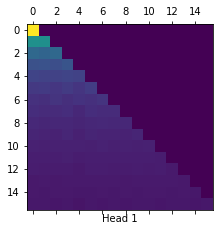

transformer_layer_17_attention
(440, 1, 16, 16)


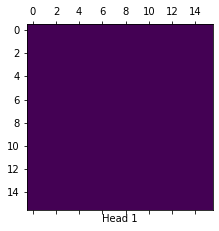

In [66]:
 for k, v in sample_attn.items():
  print(k)
  print(v.shape)
  tf_utils.plot_attention_weights(v[0])

In [67]:
train_step_signature = [
    tf.TensorSpec(shape=(None, *sample_batch.shape[1:]), dtype=tf.float32),
    # tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    # tf.TensorSpec(shape=(), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inputs):
  """
    :param inputs: (N, T, 1) the raw audio waveform!
  """

  # # TODO, move this to 'encode' function
  # quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, inputs, level=LEVEL) # (N, T_compressed)

  # # latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=0) # TODO: this is temporary, using the label token embeddings instead!
  # latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=CODEBOOK_SIZE-1) # TODO: this is temporary, using the label token embeddings instead!
  # # print(latent_input.numpy(), latent_codes.shape)
  # target = latent_codes

  # with tf.GradientTape() as tape:
  #   pred_logits, attn_weights = automha(latent_input, training=True)

  #   loss = autoregressive.loss_function(target, pred_logits, loss_fn=ent_loss_fn) # loss per token

  ## Conditioning version
  quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, inputs, level=LEVEL) # (N, T_compressed)
  _, latent_codes_upper = get_latent_codes(loaded_vqvae_trainer, inputs, level=LEVEL+1)

  # latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=0) # TODO: this is temporary, using the label token embeddings instead!
  latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=CODEBOOK_SIZE-1) # TODO: this is temporary, using the label token embeddings instead!
  # print(latent_input.numpy(), latent_codes.shape)
  target = latent_codes

  with tf.GradientTape() as tape:
    pred_logits, attn_weights = automha(latent_input, x_cond=latent_codes_upper, training=True)

    loss = autoregressive.loss_function(target, pred_logits, loss_fn=ent_loss_fn) # loss per token

  gradients = tape.gradient(loss, automha.trainable_variables)
  automha_optimizer.apply_gradients(zip(gradients, automha.trainable_variables))

  train_loss(loss)
  train_accuracy(autoregressive.accuracy_function(target, pred_logits))

  return attn_weights

In [68]:
def test_step(model, inputs, test_inputs, epoch=0):
  # Test Data Set
  train_loss.reset_state()
  train_accuracy.reset_state()
  for (batch, (X, Y)) in enumerate(test_dataset):
    ## Conditioned on upper
    _, latent_codes_upper = get_latent_codes(loaded_vqvae_trainer, X, level=LEVEL+1)
    # print(batch)
    quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, X, level=LEVEL) # (N, T_compressed)

    latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=CODEBOOK_SIZE-1) # TODO: this is temporary, using the label token embeddings instead!
    target = latent_codes

    pred_logits, attn_weights = model(latent_input, training=False, x_cond=latent_codes_upper)

    loss = autoregressive.loss_function(target, pred_logits, loss_fn=ent_loss_fn) 
    train_loss(loss)
    train_accuracy(autoregressive.accuracy_function(target, pred_logits))

  print(f'Testing performance: Loss {train_loss.result():.4f}; Perplexity (exp of loss_per_word): {tf.math.exp(train_loss.result()):.5f}; Accuracy {train_accuracy.result():.4f}')

  print(f"-------------------------------------Validate Test Samples Performance------------------------------------------")
  _, latent_codes_test_upper = get_latent_codes(loaded_vqvae_trainer, test_inputs, level=LEVEL+1)
  _, latent_codes_test = get_latent_codes(loaded_vqvae_trainer, test_inputs, level=LEVEL)
  latent_input_test = tf.pad(latent_codes_test[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=CODEBOOK_SIZE-1) # TODO: this is temporary, using the label token embeddings instead!
  # print(latent_input.numpy())
  target_test = latent_codes_test

  # pred_logits_test, attn_weights_test = model(latent_input_test, training=False)
  pred_logits_test, attn_weights_test = model(latent_input_test, training=False, x_cond=latent_codes_test_upper)

  loss_test = autoregressive.loss_function(target_test, pred_logits_test, loss_fn=ent_loss_fn)

  print(f'Testing Samples Loss {loss_test:.4f}; Perplexity (exp of loss_per_word): {tf.math.exp(loss_test):.5f}; Accuracy {autoregressive.accuracy_function(target_test, pred_logits_test):.4f}')
  print(">>>>>>>>>>> Top 100 of Test Target: ", target_test[0][:100])
  print(">>>>>>>>>>> Top 100 of Test Preds: ", tf.argmax(pred_logits_test, axis=2)[0][:100])


  for k, v in attn_weights_test.items():
    print(k)
    print(v.shape)
    tf_utils.plot_attention_weights(v[0])

  tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, test_samples, level=LEVEL, if_decode=True, latent_code=tf.argmax(pred_logits_test, axis=-1), if_sample=False)
  
  # Training Samples
  print(f"-------------------------------------Validate Training Samples Performance--------------------------------------")
  _, latent_codes_upper = get_latent_codes(loaded_vqvae_trainer, inputs, level=LEVEL+1)
  quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, inputs, level=LEVEL) # (N, T_compressed)

  latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=CODEBOOK_SIZE-1) # TODO: this is temporary, using the label token embeddings instead!
  # print(latent_input.numpy())
  target = latent_codes

  # pred_logits, attn_weights = model(latent_input, training=False)
  pred_logits, attn_weights = model(latent_input, training=False, x_cond=latent_codes_upper)

  loss = autoregressive.loss_function(target, pred_logits, loss_fn=ent_loss_fn) # loss per token

  print(f'Training Samples Loss {loss:.4f}; Perplexity (exp of loss_per_word): {tf.math.exp(loss):.5f}; Accuracy {autoregressive.accuracy_function(target, pred_logits):.4f}')
  print(">>>>>>>>>>> Top 100 of Train Target: ", target[0][:100])
  print(">>>>>>>>>>> Top 100 of Train Preds: ", tf.argmax(pred_logits, axis=2)[0][:100])

  # Plot Attentions
  for k, v in attn_weights.items():
    print(k)
    print(v.shape)
    tf_utils.plot_attention_weights(v[0])
  # ex_attention_heads_first = sample_attn['decoder_layer{}_attention'.format(1)] # Last encoder block

  # ex_attention_heads_last = sample_attn['decoder_layer{}_attention'.format(MHA_DEPTH)] # Self attention block

  # 
  # print(ex_attention_heads_first.shape)

  # plot_attention_weights(ex_attention_heads_first[0])
  # plot_attention_weights(ex_attention_heads_last[0])

  # Reconstruction and comparison
  # Greedy Sampling also
  if epoch % 20 ==0:
  # if epoch+1 % 100 ==0:
    # Sampling is a bit costy....
    tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=LEVEL, if_decode=True, latent_code=tf.argmax(pred_logits, axis=-1), if_sample=True, prior_model=model)
  else:
    tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=LEVEL, if_decode=True, latent_code=tf.argmax(pred_logits, axis=-1), if_sample=False)

  return pred_logits, attn_weights


In [ ]:
## [DEBUG] Positional Embedding learning
ini_pos_embeddings = automha.x_pos_embedding.embeddings.numpy()
print(ini_pos_embeddings, ini_pos_embeddings.shape)
print(automha.x_pos_embedding.get_weights()[0])
ini_emb = automha.x_embedding.get_weights()[0]
ini_emb.shape

In [84]:
## [DEBUG] Upper_level token Conditioner weights
len(automha.conditioner.get_weights()), len(automha.conditioner.trainable_variables)
print([var.name for var in automha.conditioner.trainable_variables])
ini_cond_weights = automha.conditioner.get_weights()

['embedding_4/embeddings:0', 'conv1d_211/kernel:0', 'conv1d_211/bias:0', 'dilated_cov1d_dr-1/kernel:0', 'dilated_cov1d_dr-1/bias:0', 'conv1d_212/kernel:0', 'conv1d_212/bias:0', 'dilated_cov1d_dr-3/kernel:0', 'dilated_cov1d_dr-3/bias:0', 'conv1d_213/kernel:0', 'conv1d_213/bias:0', 'dilated_cov1d_dr-9/kernel:0', 'dilated_cov1d_dr-9/bias:0', 'conv1d_214/kernel:0', 'conv1d_214/bias:0', 'dilated_cov1d_dr-27/kernel:0', 'dilated_cov1d_dr-27/bias:0', 'conv1d_215/kernel:0', 'conv1d_215/bias:0', 'dilated_cov1d_dr-1/kernel:0', 'dilated_cov1d_dr-1/bias:0', 'conv1d_216/kernel:0', 'conv1d_216/bias:0', 'dilated_cov1d_dr-3/kernel:0', 'dilated_cov1d_dr-3/bias:0', 'conv1d_217/kernel:0', 'conv1d_217/bias:0', 'dilated_cov1d_dr-9/kernel:0', 'dilated_cov1d_dr-9/bias:0', 'conv1d_218/kernel:0', 'conv1d_218/bias:0', 'dilated_cov1d_dr-27/kernel:0', 'dilated_cov1d_dr-27/bias:0', 'conv1d_219/kernel:0', 'conv1d_219/bias:0', 'conv1d_transpose_19/kernel:0', 'conv1d_transpose_19/bias:0', 'dilated_cov1d_dr-1/kernel:0'

In [82]:
# train_step(sample_latent_codes_bottom)
_ = train_step(sample_batch)

In [ ]:
# [DEBUG] Checking the Positional Embeddings is getting learned
updated_pos_emb = automha.x_pos_embedding.embeddings.numpy()
tf_utils.compare_t(updated_pos_emb, ini_pos_embeddings)
# print(updated_pos_emb)

In [83]:
# [DEBUG] Checking the conditioner is getting learned
tf_utils.compare_t(ini_cond_weights[0], automha.conditioner.get_weights()[0])

(<tf.Tensor: shape=(), dtype=float32, numpy=131065.0>,
 <tf.Tensor: shape=(513, 256), dtype=float32, numpy=
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)

In [ ]:
_ = test_step(automha, train_samples, test_samples)

In [72]:
prior_train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_T, y_train))
                 .shuffle(TRAIN_SHUFFLE_SIZE, reshuffle_each_iteration=True)
                 .batch(8)
                # .batch(32)
                )
print(next(iter(prior_train_dataset))[0].shape)

(8, 28160, 1)


In [ ]:
## Combined DataSet ('Cheat' for debug test-dataset stucking performance)
len(list(train_dataset.as_numpy_iterator())), len(list(test_dataset.as_numpy_iterator()))
full_dataset = train_dataset.concatenate(test_dataset) #.shuffle(TRAIN_SHUFFLE_SIZE)#.batch(8)
len(list(full_dataset.as_numpy_iterator()))
prior_train_dataset = full_dataset

In [73]:
print(len(list(prior_train_dataset.as_numpy_iterator())))
print([b[0].shape for b in list(prior_train_dataset.as_numpy_iterator())])

119
[(8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 28160, 1), (8, 2

Epoch 1 Loss 0.1657; Perplexity (exp of loss_per_word): 1.18022; Accuracy 0.9448
Time taken for 1 epoch: 23.21 secs

Saving checkpoint for epoch 1 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmb_FactorizedAttn_CAUSALCONV_noMaskPrevRow_COND/_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROPOUT_0.0/ckpt-68
---------------------------Epoch: 0 Validation Rountine...------------------------------
Testing performance: Loss 20.9345; Perplexity (exp of loss_per_word): 1235144832.00000; Accuracy 0.1408
-------------------------------------Validate Test Samples Performance------------------------------------------
Testing Samples Loss 17.1844; Perplexity (exp of loss_per_word): 29047100.00000; Accuracy 0.2535
>>>>>>>>>>> Top 100 of Test Target:  tf.Tensor(
[173 106   1  32  50 120 466 416 338 351 128 149 230 106  57 367 245 215
 309 215 106 112 367 120 247 230 120 230 366  86 487 186 393 262  70 321
  50 297 487  20 360 347 487  76 259 145 169 208 316  92 343   1 346 172
  46 245 387 451 236 112 

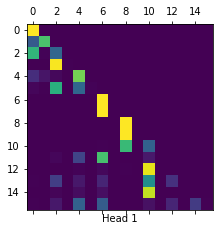

transformer_layer_17_attention
(550, 1, 16, 16)


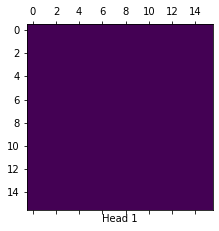

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00053144 -0.00107828 -0.00116353 ... -0.01160289 -0.01651997
 -0.00234893]
X range: [1.2842028141021729, -1.277086853981018]


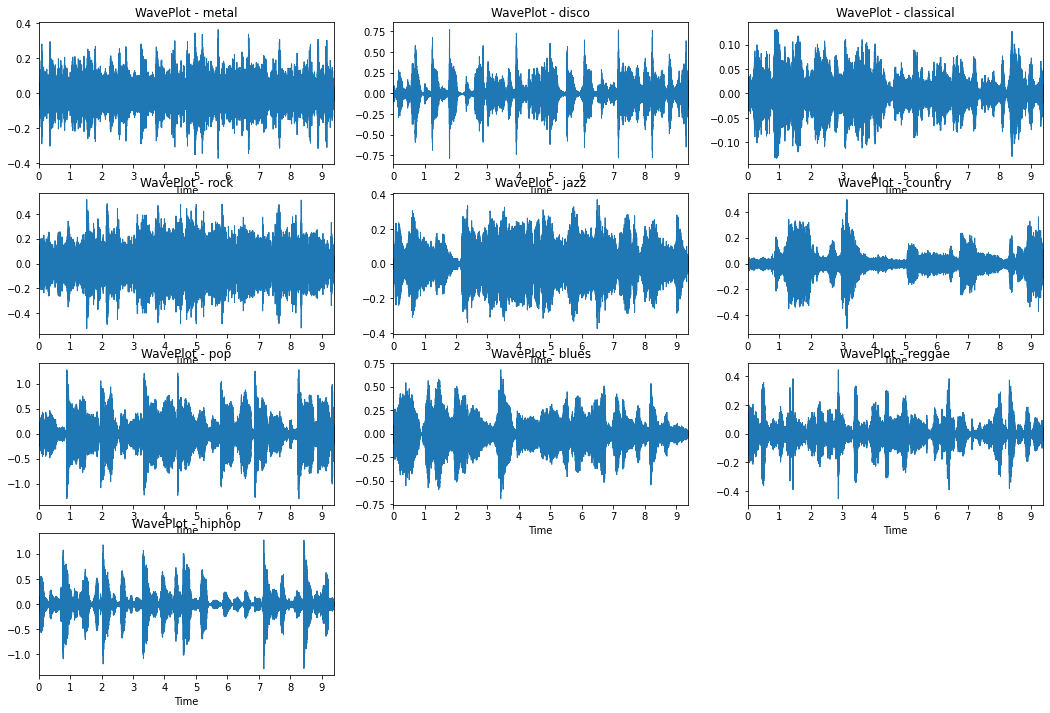

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.02137868  0.01068351  0.00910166 ... -0.00271767 -0.00602937
  0.0029994 ]
X range: [1.389129877090454, -1.3518102169036865]


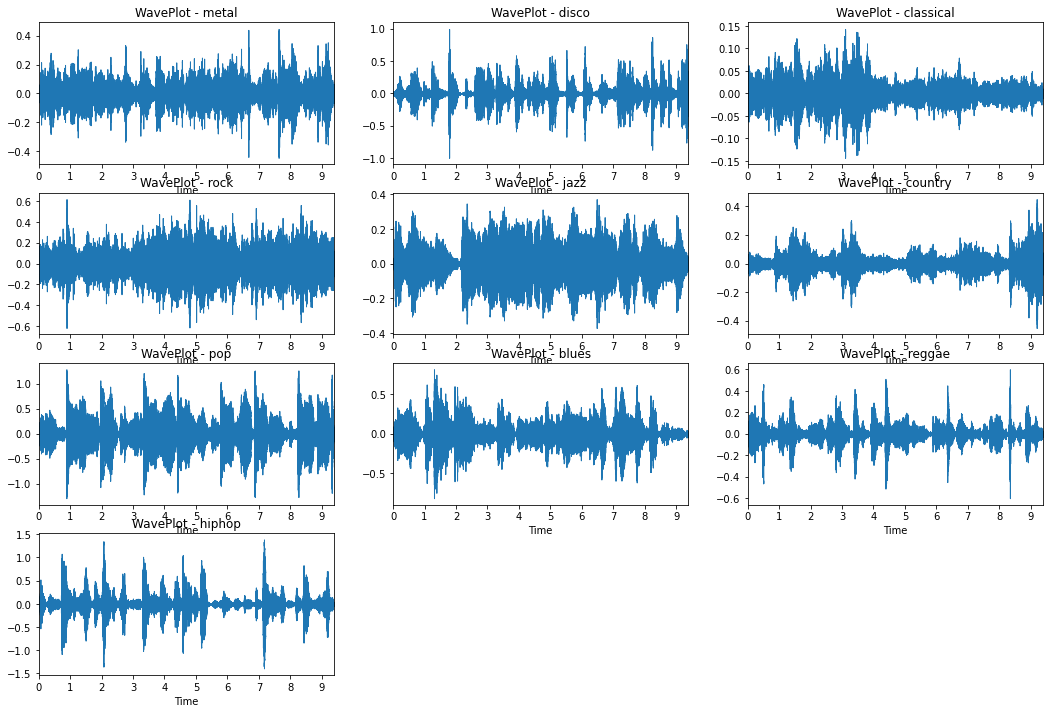

-------------------------------------Validate Training Samples Performance--------------------------------------
Training Samples Loss 0.1568; Perplexity (exp of loss_per_word): 1.16980; Accuracy 0.9491
>>>>>>>>>>> Top 100 of Train Target:  tf.Tensor(
[308 218 192 390  62   8 453 297 381 321 463 250 355 217 453 152 429  97
 258 445 481 263 185  49  90 238 193 238  49 185 312 152  78 261 121  49
 316 217 479 141 413 370  14 297 312 136 375 258 508 357 375 477 457 238
 505 262 503   8 498 324 164 332 156 445 409  90  97 210 413 193 261 484
 364  57 315 487 364 381 492 100  63  23 193  69  24 381 381  78 457 413
 487 261 487 258 340 263  14 393 217 393], shape=(100,), dtype=int64)
>>>>>>>>>>> Top 100 of Train Preds:  tf.Tensor(
[355 218 192 390  62   8 453 378 381 321 463 250 355 217 453 152 429  97
 258 445 114 263 372  49 263 238 193 238 185 185 312 152  78 261 121  49
 316 217 479 141 413 370  14 297 312 136 375 407 508 357 375 477 457 238
 505 262 503  57 498 324 164 451 156 445 409  

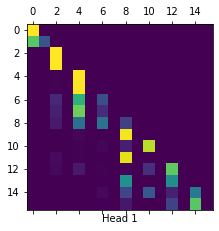

transformer_layer_17_attention
(550, 1, 16, 16)


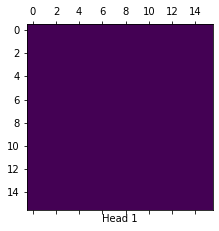

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.02448012  0.07036518  0.06209352 ... -0.04030317 -0.08214217
 -0.14540997]
X range: [1.1158572435379028, -1.2354013919830322]


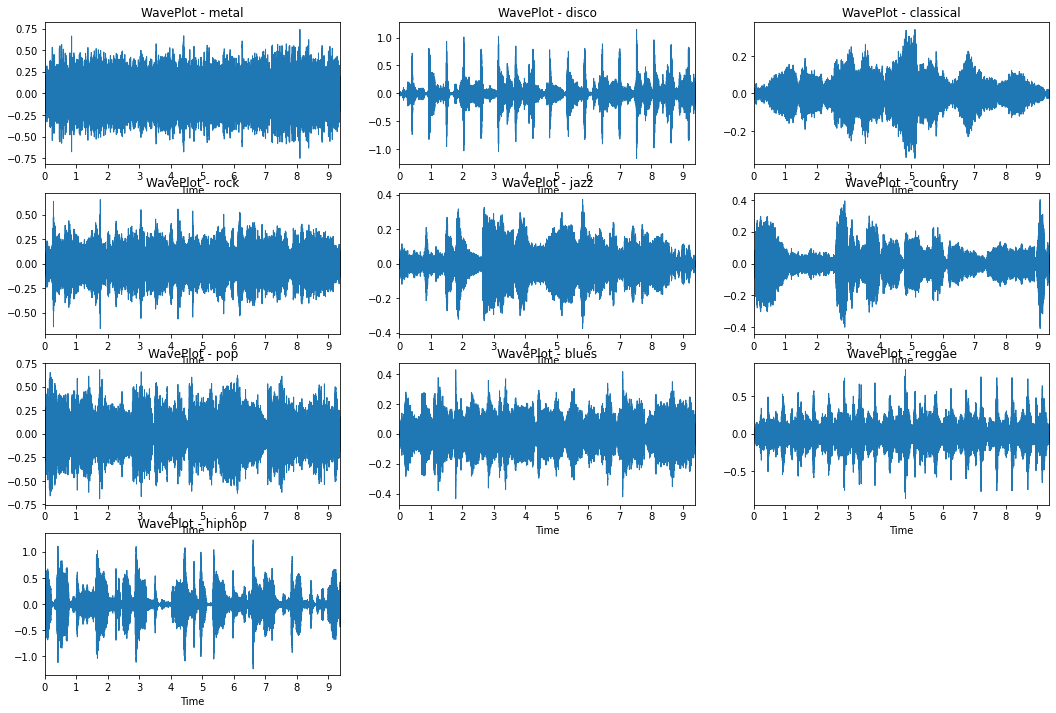

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.02448012  0.07036521  0.06209351 ... -0.04035524 -0.08192205
 -0.1450638 ]
X range: [1.115769624710083, -1.117891550064087]


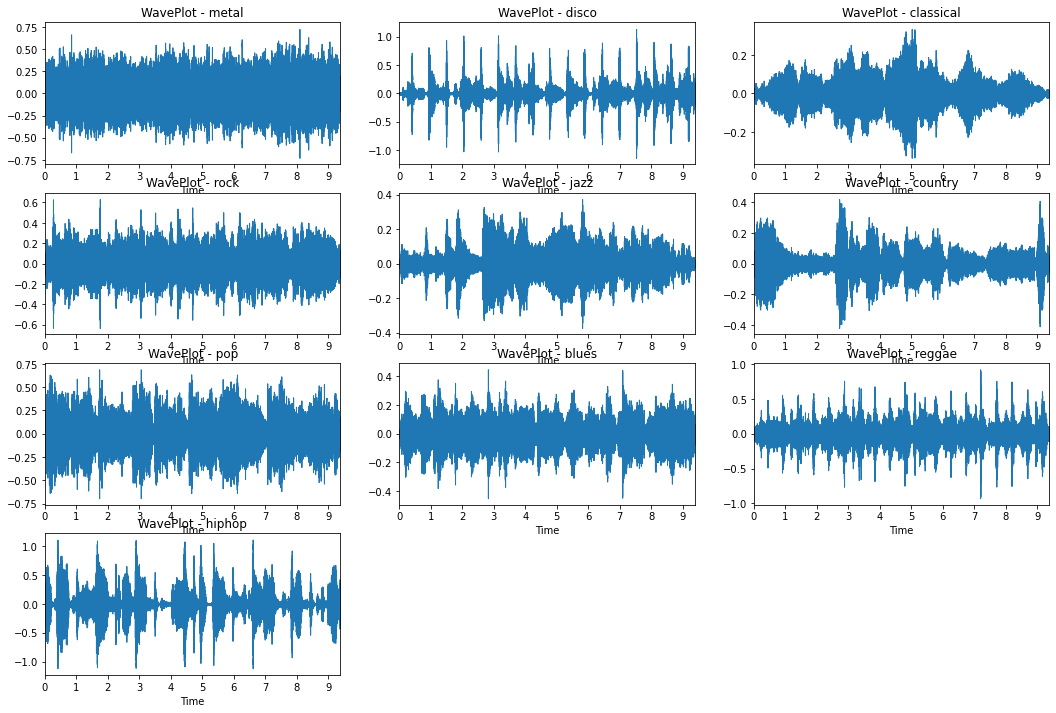

------------------------------- Auto-regressive Sampling in process..........-----------------------------
[DEBUG SAMPLING] Random Gumbel Noise Sample at each step


In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  # Reset Metrics per Epoch
  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (X, Y)) in enumerate(prior_train_dataset):
    # TODO: Make Y (class label useful...)
    # print(f"Batch {batch}, Input Shape: {X.shape}")
    train_step(X)

    # if batch % 50 == 0:
    #   print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f}; Perplexity (exp of loss_per_word): {tf.math.exp(train_loss.result()):.5f}; Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

  if epoch % 5 == 0:
     ckpt_save_path = ckpt_manager.save()
     print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
     print("---------------------------Epoch: {} Validation Rountine...------------------------------".format(epoch))
    #  print("-----------------------------------Training Samples...-----------------------------------")
     test_step(automha, train_samples, test_samples, epoch)

  # print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f}; Perplexity (exp of loss_per_word): {tf.math.exp(train_loss.result()):.5f}; Accuracy {train_accuracy.result():.4f}')

  # print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

In [ ]:
### Validate No further update to the VQ Codebook
print(tf.reduce_sum(tf.cast(loaded_vqvae_trainer.vqs[0].embeddings != ini_emb_bottom, tf.float32)))
print(tf.reduce_sum(tf.cast(loaded_vqvae_trainer.vqs[1].embeddings != ini_emb_top, tf.float32)))

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
# Inspect the weights
logits, attn_first = test_step(train_samples)

In [ ]:
for k, v in attn_first.items():
  print(k)
  print(v.shape)
  print(v[0][0])

In [ ]:
greedy_sample = tf.argmax(logits, axis=-1)
# print(greedy_sample[0])
print(attn_first[0][0])

tf.Tensor(
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.5010419  0.49895808 0.         ... 0.         0.         0.        ]
 [0.33593434 0.33337134 0.33069432 ... 0.         0.         0.        ]
 ...
 [0.00113787 0.00114433 0.00114291 ... 0.00113547 0.         0.        ]
 [0.00114928 0.00113585 0.00114567 ... 0.00113969 0.00112858 0.        ]
 [0.00113233 0.00114261 0.00114168 ... 0.00113352 0.00113883 0.00113372]], shape=(880, 880), dtype=float32)


In [ ]:
# DEBUG
for (batch, (X, Y)) in enumerate(train_dataset):
  quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, X, level=0)
  print(tf.reduce_max(latent_codes), tf.reduce_min(latent_codes))
  assert tf.reduce_max(latent_codes).numpy() < 512

#### Prior Model Storage

In [ ]:
PRIOR_VERSION="multiheadAttnBasedPriorForBottom"
model_storage_path = './colab_storage/VQVAE/cp/{}/{}/'.format("prior", PRIOR_VERSION)

In [ ]:
automha.save(model_storage_path)

INFO:tensorflow:Assets written to: ./colab_storage/VQVAE/cp/prior/multiheadAttnBasedPriorForBottom/assets


INFO:tensorflow:Assets written to: ./colab_storage/VQVAE/cp/prior/multiheadAttnBasedPriorForBottom/assets


In [ ]:
### Restore From Saved_Model
# It can be used to reconstruct the model identically.
loaded_automha = keras.models.load_model(model_storage_path)

# Let's check:
np.testing.assert_allclose(
    automha.predict(sample_latent_codes_bottom)[0], loaded_automha.predict(sample_latent_codes_bottom)[0],
    verbose=True
)


In [ ]:
# automha.predict(sample_latent_codes_bottom)[0].shape

(8, 880, 513)

## Sampling/Inference

In [ ]:
import tensorflow_probability as tfp

importlib.reload(autoregressive)
importlib.reload(data_utils)
importlib.reload(tf_utils)
importlib.reload(multi_head_attention)
importlib.reload(factorized_attention)
importlib.reload(transformer)
importlib.reload(autoregressive_fmha)

<module 'src.autoregressive.autoregressive_fmha' from 'C:\\Users\\Zeyu Sun\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models\\src\\autoregressive\\autoregressive_fmha.py'>

#### Load or Store Model

In [ ]:
PRIOR_VERSION
prior_model_path

'./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmb_FactorizedAttn_CAUSALCONV_noMaskPrevRow/_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROPOUT_0.0/'

In [ ]:
stable_prior_model_path='./colab_storage/VQVAE/cp/prior/stable/{}'.format(PRIOR_VERSION)
stable_prior_model_path

'./colab_storage/VQVAE/cp/prior/stable/Prior_Bottom_PosEmb_FactorizedAttn_CAUSALCONV_noMaskPrevRow'

In [ ]:
# automha.save(stable_prior_model_path)
automha.save_weights(stable_prior_model_path)
# automha.load_weights(prior_model_path)

In [ ]:
prior_model = autoregressive_fmha.FMHABasedAutoregressiveModel(context_length=sample_latent_codes_bottom.shape[1:], target_vocab_size=CODEBOOK_SIZE, 
                                                               width=MHA_MODEL,depth=MHA_DEPTH, heads=MHA_HEADS, blocks=BLOCKS, attn_stacks=ATTN_STACKS, 
                                                               drop_out_rate=DROP_OUT_RATE) # drop_out_rate=0.0) # NO DropOut

[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention


In [ ]:
# Load CheckPoint
prior_model.load_weights(stable_prior_model_path)

Testing performance: Loss 23.5714; Perplexity (exp of loss_per_word): 17256011776.00000; Accuracy 0.1298
-------------------------------------Validate Test Samples Performance------------------------------------------
Testing Samples Loss 19.2301; Perplexity (exp of loss_per_word): 224653584.00000; Accuracy 0.2477
>>>>>>>>>>> Top 100 of Test Target:  tf.Tensor(
[173 106   1  32  50 120 466 416 338 351 128 149 230 106  57 367 245 215
 309 215 106 112 367 120 247 230 120 230 366  86 487 186 393 262  70 321
  50 297 487  20 360 347 487  76 259 145 169 208 316  92 343   1 346 172
  46 245 387 451 236 112  70 379 145 226 450 120 156 409 195 463  32 106
 120 141 272 313 390 393 468 144 487 360 281 156 205 489 245 377 346 196
 343  97  68   1 182 200 402  54  92 469], shape=(100,), dtype=int64)
>>>>>>>>>>> Top 100 of Test Preds:  tf.Tensor(
[ 32 411 247 149 173 455 337 351  69 139 416 139  32  92 375 107 106 168
 225 171 383  50  50 136  92 416 141 214  54 141 422 290 365 329 478  17
 148 141

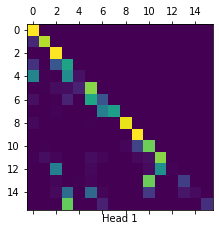

transformer_layer_17_attention
(550, 1, 16, 16)


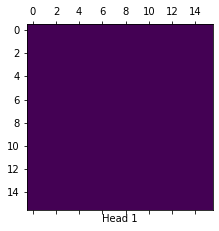

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00053144 -0.00107828 -0.00116353 ... -0.01160289 -0.01651997
 -0.00234893]
X range: [1.2842028141021729, -1.277086853981018]


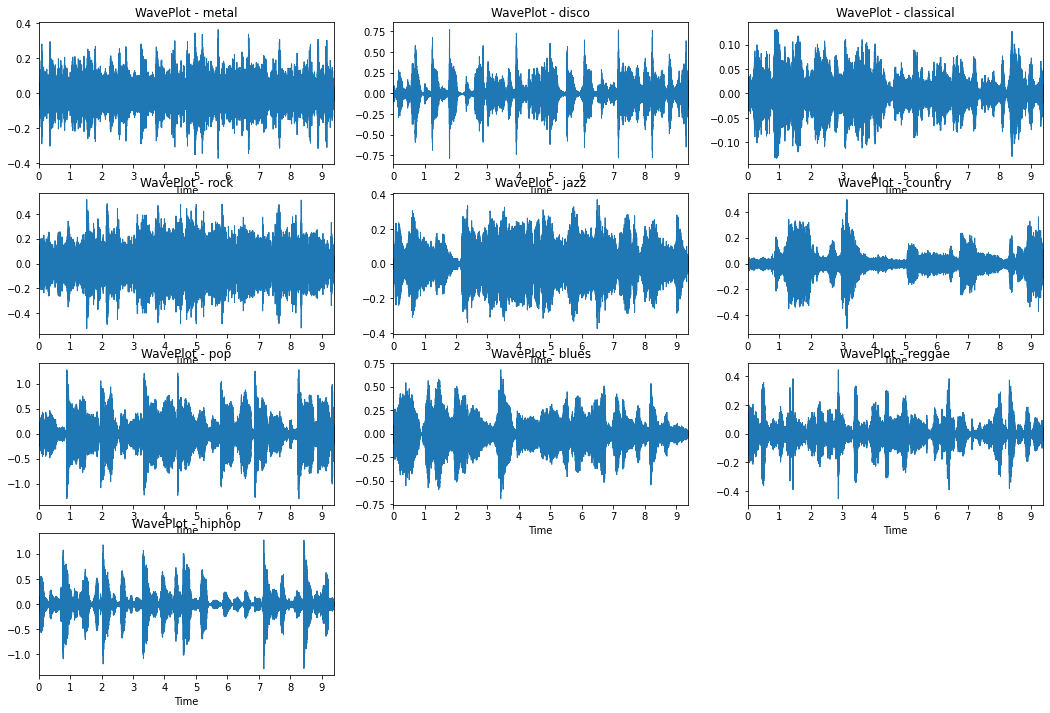

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00379852  0.00071148 -0.00347889 ... -0.00637237 -0.01288149
 -0.00220099]
X range: [0.9485123753547668, -0.9258314967155457]


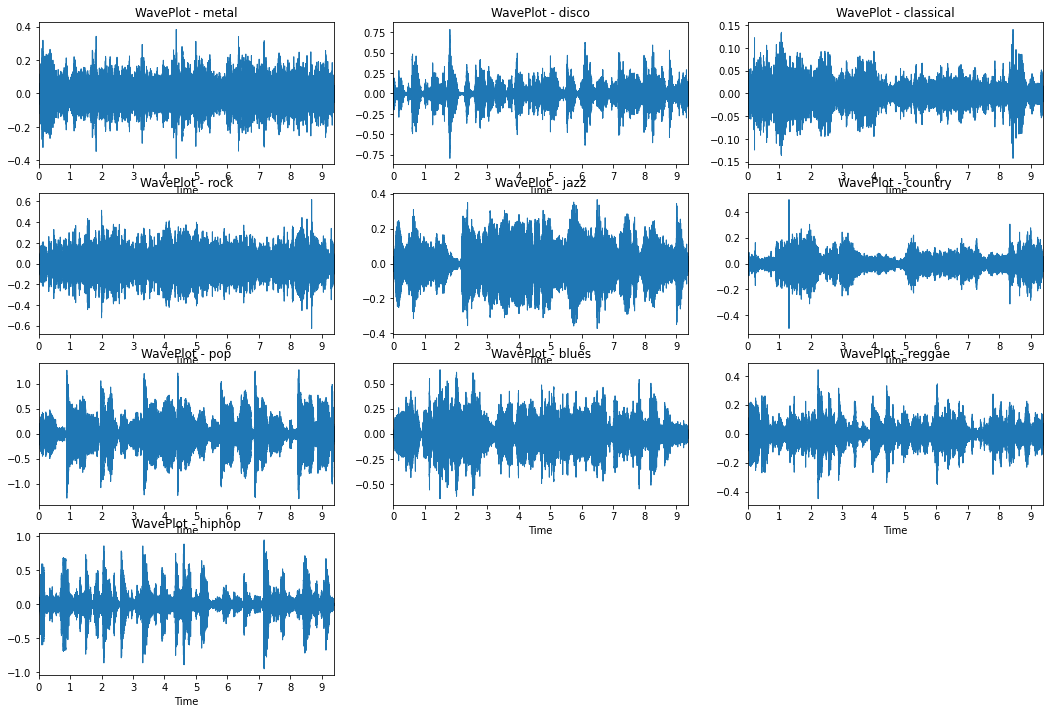

-------------------------------------Validate Training Samples Performance--------------------------------------
Training Samples Loss 0.1436; Perplexity (exp of loss_per_word): 1.15439; Accuracy 0.9558
>>>>>>>>>>> Top 100 of Train Target:  tf.Tensor(
[308 218 192 390  62   8 453 297 381 321 463 250 355 217 453 152 429  97
 258 445 481 263 185  49  90 238 193 238  49 185 312 152  78 261 121  49
 316 217 479 141 413 370  14 297 312 136 375 258 508 357 375 477 457 238
 505 262 503   8 498 324 164 332 156 445 409  90  97 210 413 193 261 484
 364  57 315 487 364 381 492 100  63  23 193  69  24 381 381  78 457 413
 487 261 487 258 340 263  14 393 217 393], shape=(100,), dtype=int64)
>>>>>>>>>>> Top 100 of Train Preds:  tf.Tensor(
[ 32 291 192 421  62   8 453 297 352 321 286 250 478 217 453 152 429  97
 109 445 133 263 185  49  90 238 193 238  49 185 312 152  78 261 121  49
 316 217 479 141 413 370  14 297 312 136 375 258 508 357 375 477 457 238
 505 262 503   8 498 324 164 332 156 445 409  

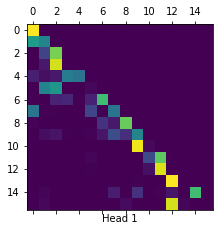

transformer_layer_17_attention
(550, 1, 16, 16)


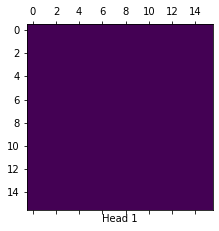

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.02448012  0.07036518  0.06209352 ... -0.04030317 -0.08214217
 -0.14540997]
X range: [1.1158572435379028, -1.2354013919830322]


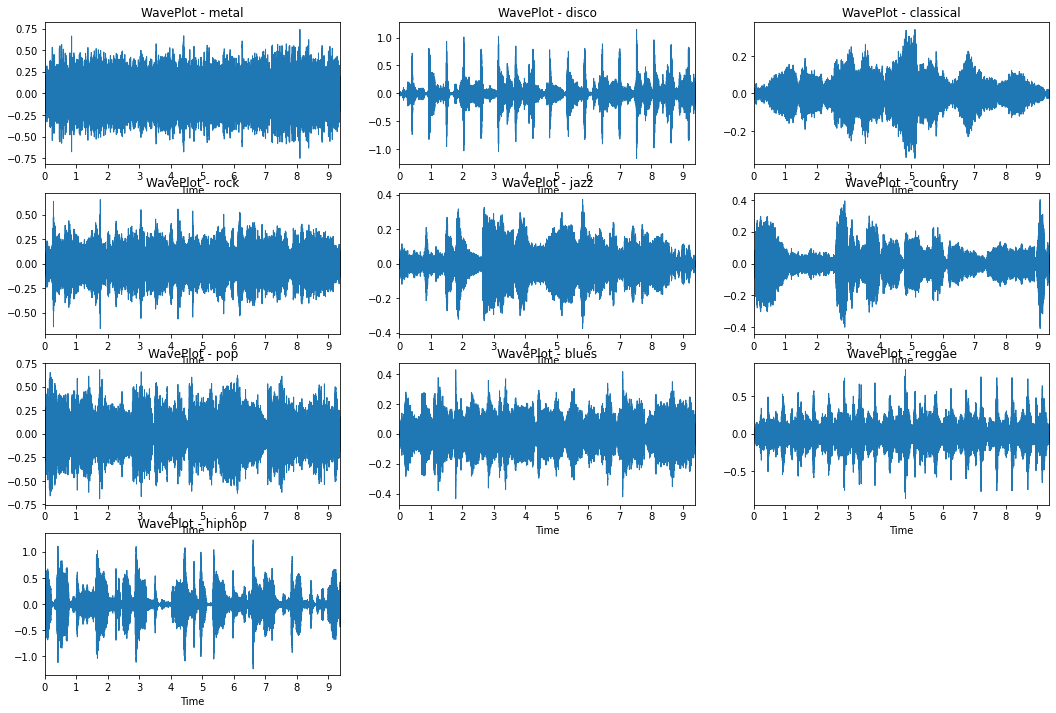

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [-0.01036811 -0.00527153 -0.02011051 ... -0.04030317 -0.08214216
 -0.1454099 ]
X range: [1.097167730331421, -1.2386788129806519]


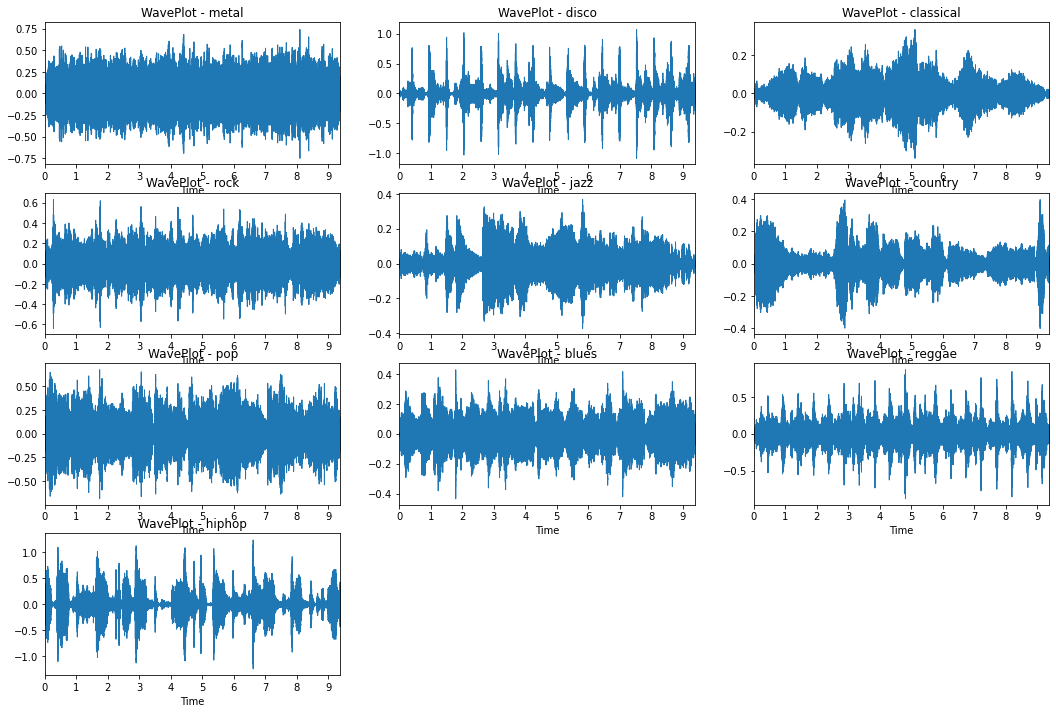

In [ ]:
## Validate The Loaded Prior Model
_ = test_step(prior_model, train_samples, test_samples, 1)

#### Categorical Distribution

In [ ]:
prob = np.array([[0.6, 0.2, 0.2], [0.0, 0.0, 1.0]])

In [ ]:
# dist = tfp.distributions.Categorical(probs=prob)
dist = tfp.distributions.RelaxedOneHotCategorical(1.0, probs=prob)

In [ ]:
dist.sample()

<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[0.83956628, 0.08162868, 0.07880504],
       [0.        , 0.        , 1.        ]])>

#### Inspect the sample Quality

In [ ]:
sampled_codes = prior_model.sample(n_samples=2)

[DEBUG SAMPLING] Random Gumbel Noise Sample at each step


In [ ]:
sampled_codes.shape

TensorShape([2, 881])

Sampled output shape: [  2 880] (with Start Token...)
tf.Tensor(
[[106 435 167 ...   1 351 173]
 [366 247  97 ... 343 411 411]], shape=(2, 880), dtype=int64)
(2, 28160, 1)
-------------------------------- Reconstruction from Prior Sampling (non-prime)... --------------------------


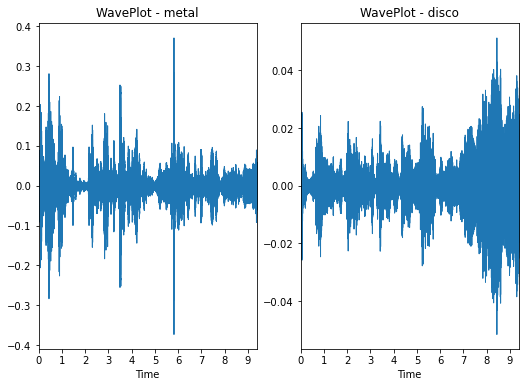

In [ ]:
# remove the start token
# sampled_recons = loaded_vqvae_trainer.decode(sampled_codes[:, 1:], level=LEVEL).numpy()
# print(sampled_recons.shape, type(sampled_recons))

# print("-------------------------------- Reconstruction from Prior Sampling (non-prime)... --------------------------")

# fig = plt.figure(figsize=(18, 6))

# for i in range(sampled_recons.shape[0]):
#     waves = sampled_recons[i]
#     plt.subplot(1, 4, i + 1)

#     if i == 3:
#         print("X': ", waves.squeeze())
#         print(f"X range: [{np.amax(waves)}, {np.amin(waves)}]")

#     librosa.display.waveplot(waves.squeeze(), sr=SAMPLE_RATE)
#     plt.title(f"WavePlot - {idx_to_genres[i]}")
#     # # plt.tight_layout()
#     # ret.append(predictions[i])

# plt.show()
sampled_recons = tf_utils.decode_latent(loaded_vqvae_trainer, sampled_codes[:, 1:], LEVEL)

In [ ]:
## Inspect the audio
ipd.Audio(sampled_recons[0].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
ipd.Audio(sampled_recons[1].squeeze(), rate=SAMPLE_RATE) # Metal Recon

###### Random Search

In [ ]:
rs_sample, rs_best_loss = prior_model.random_sample(ent_loss_fn, seq_length=sample_latent_codes_bottom.shape[1], iterations=100, batch_per_iter=10, token_freq=0.1)

[DEBUG SAMPLING] Random Gumbel Noise Sample at each step
Best Loss: 0.03499259799718857 for Iteration: 0-0
Token 403 occurred 832 Times! Skipping...
Best Loss: 0.036186106503009796 for Iteration: 0-1
Token 137 occurred 827 Times! Skipping...
Best Loss: 0.04287734627723694 for Iteration: 0-2
Token 406 occurred 816 Times! Skipping...
Best Loss: 0.09896065294742584 for Iteration: 0-3
Token 490 occurred 680 Times! Skipping...
Best Loss: 0.36431434750556946 for Iteration: 0-4
Token 221 occurred 151 Times! Skipping...
Best Loss: 0.4139004051685333 for Iteration: 0-5
[DEBUG SAMPLING] Random Gumbel Noise Sample at each step
Best Loss: 0.24356013536453247 for Iteration: 1-0
Token 406 occurred 169 Times! Skipping...
Best Loss: 0.3395119309425354 for Iteration: 1-1
Token 221 occurred 211 Times! Skipping...
Best Loss: 0.34290507435798645 for Iteration: 1-2
[DEBUG SAMPLING] Random Gumbel Noise Sample at each step
Best Loss: 0.1317680925130844 for Iteration: 2-0
Token 198 occurred 271 Times! Skippin

In [ ]:
rs_sample.shape, rs_best_loss

(TensorShape([881]), <tf.Tensor: shape=(), dtype=float32, numpy=0.3142197>)

In [ ]:
rs_sample[1:][tf.newaxis]

<tf.Tensor: shape=(1, 880), dtype=int64, numpy=
array([[166, 149, 167, 361, 341,  96, 454, 221, 230,  96, 423, 410, 447,
        103, 331, 103, 331, 167, 331, 184, 318, 167, 152, 402, 119,  78,
         96, 447,  96, 206, 103, 447, 103, 331, 167, 331, 167, 331, 167,
        331, 298,  96, 341,  96, 144,  96, 341,  96, 447, 103, 423, 229,
        331, 372, 398, 344,  96, 454,  96, 447,  96, 454,  96, 447, 307,
        454, 331, 372, 331, 144,  96, 454, 331, 454, 331, 372, 307, 116,
         96, 454, 227, 341, 447, 454, 331, 341,  96, 144,  96, 454, 454,
        144, 227, 327, 506, 454, 116, 327, 327, 327, 327, 144, 454, 144,
        454, 454, 307, 307, 116, 454, 454, 287, 227, 318, 144, 454,   5,
         70,   5, 343, 144, 144, 343, 227, 227, 227, 150, 240, 343, 341,
        227, 307, 307, 150, 341, 144, 341, 221, 227, 307,  36, 341,   5,
        240,  77, 198, 327, 227, 227, 227, 377, 102, 421, 149, 227, 227,
        227, 221, 341, 240,   5, 199, 150, 199,  73, 199, 227, 227, 199,
   

Sampled output shape: [  1 880] (with Start Token...)
tf.Tensor(
[[166 149 167 361 341  96 454 221 230  96 423 410 447 103 331 103 331 167
  331 184 318 167 152 402 119  78  96 447  96 206 103 447 103 331 167 331
  167 331 167 331 298  96 341  96 144  96 341  96 447 103 423 229 331 372
  398 344  96 454  96 447  96 454  96 447 307 454 331 372 331 144  96 454
  331 454 331 372 307 116  96 454 227 341 447 454 331 341  96 144  96 454
  454 144 227 327 506 454 116 327 327 327 327 144 454 144 454 454 307 307
  116 454 454 287 227 318 144 454   5  70   5 343 144 144 343 227 227 227
  150 240 343 341 227 307 307 150 341 144 341 221 227 307  36 341   5 240
   77 198 327 227 227 227 377 102 421 149 227 227 227 221 341 240   5 199
  150 199  73 199 227 227 199 341 311 377 411  84 227 398 424   7 421 398
  381 177 167 227   7 144 144 327 227 227 221   5   5 253 343 221 303 221
  227 227 271 343   5   5 390 221 411 227 227 196 487 240 144 144 327 307
  227 227 221   5 240 144   5 150   7 227 343 3

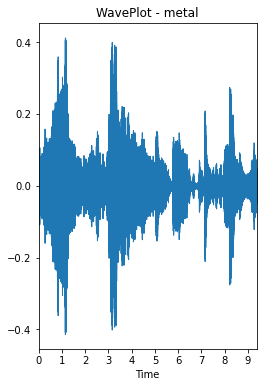

In [ ]:
sampled_recons = tf_utils.decode_latent(loaded_vqvae_trainer, rs_sample[1:][tf.newaxis], LEVEL)

In [ ]:
ipd.Audio(sampled_recons[0].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
# DEBUG
tf.unique_with_counts(rs_sample)

UniqueWithCounts(y=<tf.Tensor: shape=(102,), dtype=int64, numpy=
array([512,  70, 150, 368, 394, 101,  94, 317, 224,  75, 391, 477,  54,
       348, 476, 479, 494, 341,  34, 242, 328, 140,  19, 280, 475, 506,
       401,  33, 344, 198,  73, 278,   5, 390, 372, 474, 149, 240, 116,
        16, 155, 322, 269,  82, 393, 299, 199, 399, 489,  81,  83, 165,
       273, 454, 311, 104, 302,  85,  68, 334,  30, 421, 382, 307, 339,
       330, 431, 437, 201, 352,  90, 428,  88,  67, 443, 501, 184,  98,
       471, 279,  76, 361,  77, 231, 272, 186, 195, 129, 169, 185, 212,
       386, 435, 456, 228, 459, 465,  99, 246,  93, 355,  12], dtype=int64)>, idx=<tf.Tensor: shape=(881,), dtype=int32, numpy=
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   6,   7,   9,   6,
        10,   3,   6,   8,   9,   6,   9,  11,  12,  11,  11,  13,  14,
        15,  11,   9,   6,  16,   9,  11,   6,  17,  18,  18,  19,  15,
        17,  19,  20,  21,  22,  23,  14,  17,  14,  24,  14,  14,  14,
        14,  14

In [ ]:
tf.unique_with_counts(sampled_codes[0])

UniqueWithCounts(y=<tf.Tensor: shape=(34,), dtype=int64, numpy=
array([512, 411, 354,  32, 149, 399, 282, 390, 123,  77, 402, 310, 346,
       221, 200, 150, 151, 435, 364, 320,  29, 480, 277, 137,  70, 290,
       214, 191, 464, 326, 174, 238, 143,  58], dtype=int64)>, idx=<tf.Tensor: shape=(881,), dtype=int32, numpy=
array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  4,  4,  5,  5,  6,  7,
        8,  9, 10, 11,  3,  1, 12,  1, 12, 12,  1,  1,  1,  1, 13, 13,  1,
        1,  1,  1,  1,  1,  1, 12, 12, 12, 14,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  3,  4,  4,  3,  4, 15,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 13, 13,  1,  1,  1,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  1,  1,  1,  1,
        1,  1,  1,  1,  3,  4, 16,  3,  3,  3,  1,  1,  1,  1,  1, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  1,  1,  1, 17,  1,  1,  1,
    